In [150]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import os
import time
import pickle
from scipy import stats
import statsmodels.formula.api as sm
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

/opt/anaconda/anaconda3/lib/python3.5/site-packages/matplotlib/backends/__init__.py:60: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  # imports. 0 means only perform absolute imports.
/opt/anaconda/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  for gs_exec in gs_execs:


# Part 1: Format all data together

### Get data from mysql
SELECT financialsALL.BvD, `consolidationCode`, `year`, financialsALL.`operatingRevenue`, `PLbeforeTax`, `Taxation`, `PLafterTax`, `deferredTaxes`, coreNACE, entityType, fixedAssets, tangibleFixedAssets,financialsALL.numberEmployees,loans,retainedEarnings, incomeTaxPayable,
companyName, city, iso2, keepForm, standardisedLegalForm, status
FROM `financialsALL`
JOIN entitiesALL
ON entitiesALL.BvD = financialsALL.BvD
WHERE Taxation is not null
INTO OUTFILE '/datastore0/mysql/tmp/tax_2018.csv' FIELDS TERMINATED BY '\t' ENCLOSED BY '' LINES TERMINATED BY '\n'

In [496]:
#Copy the data to the folder
!cp /datastore0/mysql/tmp/tax_2018.csv ./data/tax_2018.csv

In [7]:
#Get data on other important measures (wage cost, etc)
#cut -f 1,2,4,13,14,15,20,23,56,57,58,59 Industry-Global_financials_and_ratios-USD.txt > /datastore/shared/javier/data_common/industry_ratios_tax.tsv
other_ratios = pd.read_csv("/datastore/shared/javier/data_common/industry_ratios_tax.tsv",sep="\t",na_values=["\\N",'-',"n.a."])
vars_ = ["Intangible fixed assets","Tangible fixed assets","Other fixed assets","Cash & cash equivalent","Capital","Costs of employees","Depreciation & Amortization","Interest paid","Research & Development expenses"]
other_ratios = other_ratios.dropna(subset=vars_,how="all")
other_ratios["year"] = other_ratios["Closing date"].astype(str).str.slice(0,4).astype(int)
del other_ratios["Closing date"]
#Combine different sources
other_ratios["Costs of employees"] = other_ratios["Costs of employees"].astype(float)
other_ratios = other_ratios.groupby(["BvD ID number","Consolidation code","year"]).mean().reset_index()

other_ratios.columns = ["BvD","consolidationCode","year","intangibleFA","tangibleFA","otherFA","cash","capital","costEmployees","depreciation_amortization","interestPaid","RDexpenses"]
other_ratios.head()

,BvD,consolidationCode,year,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses
0,AE0000000390,LF,2015,NaN,NaN,NaN,NaN,816882.0,NaN,NaN,NaN,NaN
1,AE0000000417,LF,2015,NaN,NaN,NaN,NaN,81688.0,NaN,NaN,NaN,NaN
2,AE0000000848,LF,2015,NaN,NaN,NaN,NaN,81688.0,NaN,NaN,NaN,NaN
3,AE0000000862,LF,2015,NaN,NaN,NaN,NaN,272294.0,NaN,NaN,NaN,NaN
4,AE0000001011,LF,2015,NaN,NaN,NaN,NaN,81688.0,NaN,NaN,NaN,NaN


In [8]:
#load dictionaries with global ultimate owners
path = "/datastore/shared_public/process_orbis_data/data/2017_12/cleaned/ownership/"
guos = sorted([_ for _ in os.listdir(path)
    if "guo" in _])

d_guo = dict()
for guo in guos:
    with open(path+guo) as f:
        for line in f:
            splits =  line.strip().split()
            d_guo[splits[1]] = splits[-1]

    

In [9]:
#Read file
names = ["BvD", "consolidationCode", "year", "operatingRevenue", "PLbeforeTax", "Taxation", "PLafterTax", "deferredTaxes", 
         "coreNACE", "entityType", "fixedAssets", "tangibleFixedAssets","numberEmployees","loans","retainedEarnings","incomeTaxPayable",
"companyName", "city", "iso2", "keepForm", "standardisedLegalForm", "status"]
tax_data = pd.read_csv("./data/tax_2018.csv",sep="\t",names=names,na_values=["\\N"])

#add guo
tax_data["guo"] = tax_data["BvD"].apply(lambda x: d_guo[x] if d_guo.get(x) is not None else x)

#find guo multiantionasl
multinat_guo = set(tax_data.loc[tax_data["guo"].str.slice(0,2) != tax_data["BvD"].str.slice(0,2),"guo"])
domestic_guo = set(tax_data["guo"]) - multinat_guo


#load iso from BvD
bvd2iso = pd.read_csv("./data/iso_bvd.csv",sep="\t",header=None)
bvd2iso = bvd2iso.set_index(0).to_dict()[1]

#get iso codes
tax_data["iso2"] = tax_data["BvD"].apply(lambda x: bvd2iso[x] if bvd2iso.get(x) is not None else x[:2])
tax_data["iso2_guo"] = tax_data["guo"].apply(lambda x: bvd2iso[x] if bvd2iso.get(x) is not None else x[:2])

#multinational enterprises
tax_data["multinat"] = tax_data["guo"].apply(lambda x: x in multinat_guo).astype(int)

#Multinationals from the home  country
tax_data.loc[(tax_data["iso2"]==tax_data["iso2_guo"])&(tax_data["multinat"]==1),"multinat"] += 1


d_nace2letter = pickle.load(open("../data_quality/stats_office/dict_nace2letter.csv","rb"))
tax_data["letterNACE"] = tax_data["coreNACE"].apply(lambda x: d_nace2letter.get(str(x)[:2]))

#0 domestic 
#1 multinational with foreign guo
#2 multinational with domestic guo

In [312]:
cy = tax_data.loc[tax_data["iso2"]=="LU"]
cy = cy.loc[cy["entityType"]=="C"]
cy = cy.loc[cy["consolidationCode"]!="C"]
cy = cy.loc[cy["costEmployees"]>0]
cy = cy.loc[cy["PLbeforeTax"]>1E6]
cy["profitRate"] = cy["PLbeforeTax"]/cy["costEmployees"]
cy["taxRate"] = cy["Taxation"]/cy["PLbeforeTax"]
cy.head(1)

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,fixedAssets,tangibleFixedAssets,numberEmployees,loans,retainedEarnings,incomeTaxPayable,companyName,city,iso2,keepForm,standardisedLegalForm,status,guo,iso2_guo,multinat,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses,deferredTaxes_new,group_size_rev,group_size_ass,group_size_rev_u,group_size_ass_u,letterNACE,profitRate,taxRate
36343622,FR394519144,U1,2007,1103577.0,1371960.0,98741,1191759.0,NaN,7022.0,C,3280538.0,NaN,NaN,NaN,NaN,NaN,CONSEIL ETUDE REALISATION POUR LINNOVATION EN ...,NaN,LU,1,Public limited companies,Active,FR394519144,LU,0,0.0,241786.0,3038752.0,514218.0,1472099.0,682031.0,83274.0,NaN,NaN,NaN,-9.0,-9.0,7.0,8.0,M,2.01158,0.071971


In [317]:
smf.ols("profitRate ~ C(multinat) +taxRate + C(letterNACE)",data=cy.groupby(["BvD","letterNACE"]).mean().reset_index()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             profitRate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8130
Date:                Tue, 21 Aug 2018   Prob (F-statistic):              0.686
Time:                        11:24:23   Log-Likelihood:                -18065.
No. Observations:                1636   AIC:                         3.617e+04
Df Residuals:                    1617   BIC:                         3.627e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -489.0276   1335.859     -0.366      0.714   -3109.225    2131.170
C(multinat)[T.1.0]   141.4614    957.003      0.148      0.883   -1735.635    2018.558
C(multinat)[T.2.0]  1687.9407   1116.701      1.512      0.131    -502.392    3878.274
C(letterNACE)[T.D]  -296.1945   3980.786     -0.074      0.941   -8104.237    7511.848
C(letterNACE)[T.E]   372.3011   4733.383      0.079      0.937   -8911.909    9656.511
C(letterNACE)[T.F]   349.0382   1808.126      0.193      0.847   -3197.479    3895.555
C(letterNACE)[T.G]   359.8547   1492.314      0.241      0.809   -2567.218    3286.927
C(letterNACE)[T.H]   -51.8658   2054.464     -0.025      0.980   -4081.557    3977.825
C(letterNACE)[T.I]   388.5673   4230.169      0.092      0.927   -7908.623    8685.758
C(letterNACE)[T.J]    69.7662   1979.745      0.035      0.972   -3813.370    3952.903
C(letterNACE)[T.K]   628.8683   3442.796      0.183      0.855   -6123.942    7381.679
C(letterNACE)[T.L]   155.4430   4538.568      0.034      0.973   -8746.649    9057.535
C(letterNACE)[T.M]   321.4335   1966.594      0.163      0.870   -3535.908    4178.775
C(letterNACE)[T.N]  2567.8971   1299.899      1.975      0.048      18.234    5117.561
C(letterNACE)[T.P]   606.0897   1.53e+04      0.040      0.968   -2.93e+04    3.05e+04
C(letterNACE)[T.Q]   416.9554   4393.373      0.095      0.924   -8200.348    9034.259
C(letterNACE)[T.R]   188.9307   6314.667      0.030      0.976   -1.22e+04    1.26e+04
C(letterNACE)[T.S]    99.3717   3052.968      0.033      0.974   -5888.818    6087.562
taxRate             -366.1970    668.800     -0.548      0.584   -1678.003     945.609
==============================================================================
Omnibus:                     4548.371   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        109244448.217
Skew:                          34.003   Prob(JB):                         0.00
Kurtosis:                    1267.114   Cond. No.                         51.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
tax_data = pd.merge(tax_data,other_ratios,on=["BvD","consolidationCode","year"],how="left")
tax_data.head()

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,...,multinat,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses
0,ADFEB18424,C1,2013,268388023.0,98338102.0,9965376,88372726.0,NaN,6619.0,B,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADFEB18424,C1,2014,267416584.0,86691639.0,8662608,78029031.0,NaN,6619.0,B,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADFEB18424,C1,2015,271222372.0,61703158.0,2861103,58842054.0,NaN,6619.0,B,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADFEB18424,C1,2016,270773001.0,56229912.0,6668237,49561676.0,NaN,6619.0,B,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADFEB32643,C1,2013,161864963.0,63955761.0,5519158,58436603.0,NaN,6419.0,B,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tax_data.describe()

,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,fixedAssets,tangibleFixedAssets,numberEmployees,...,multinat,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses
count,1.280346e+08,1.210790e+08,1.271801e+08,1.280346e+08,1.016072e+08,3.477420e+05,1.224038e+08,1.271751e+08,0.0,8.229864e+07,...,1.280346e+08,1.221444e+08,1.235479e+08,1.220180e+08,1.127345e+08,1.219920e+08,7.286504e+07,7.471378e+07,5.761506e+07,4.011557e+06
mean,2.008781e+03,2.115526e+07,-3.267180e+07,2.883263e+05,1.940741e+06,5.346075e+07,5.113066e+03,2.107840e+07,NaN,5.198688e+01,...,1.125722e-01,2.204326e+06,9.709778e+06,9.977161e+06,4.501615e+06,4.505363e+06,9.201732e+06,1.515874e+06,2.582551e+06,2.940286e+06
std,5.465818e+00,2.330868e+10,3.902954e+11,1.325289e+09,3.919809e+09,4.333731e+08,2.054488e+03,2.701661e+10,NaN,2.125000e+05,...,3.862350e-01,2.432616e+09,1.445567e+10,1.333187e+10,3.547771e+09,1.424972e+10,5.649053e+10,2.025496e+09,6.913301e+09,9.202814e+07
min,1.931000e+03,-1.876845e+10,-4.400267e+15,-1.456854e+13,-1.135631e+13,-3.556100e+10,0.000000e+00,-7.532666e+10,NaN,-1.442841e+09,...,0.000000e+00,-2.825001e+09,-5.561000e+09,-7.662195e+10,-5.580857e+11,-7.982125e+10,-1.267295e+12,-1.806029e+11,-6.649063e+09,-9.661382e+09
25%,2.005000e+03,3.285700e+04,-8.980000e+02,0.000000e+00,-1.138000e+03,7.969450e+04,4.312000e+03,1.400000e+03,NaN,2.000000e+00,...,0.000000e+00,0.000000e+00,2.870000e+02,0.000000e+00,2.304000e+03,2.910000e+03,1.749200e+04,2.280000e+03,9.800000e+02,0.000000e+00
50%,2.010000e+03,2.256450e+05,4.801000e+03,7.500000e+02,2.409000e+03,1.161194e+06,4.729000e+03,3.601900e+04,NaN,4.000000e+00,...,0.000000e+00,0.000000e+00,1.800000e+04,0.000000e+00,1.695000e+04,1.317000e+04,8.311800e+04,9.903000e+03,5.777000e+03,0.000000e+00
75%,2.013000e+03,1.177563e+06,4.572900e+04,8.960000e+03,2.968200e+04,8.898589e+06,6.820000e+03,3.118150e+05,NaN,1.500000e+01,...,0.000000e+00,8.000000e+02,1.750330e+05,6.124000e+03,9.385800e+04,7.279000e+04,3.070000e+05,3.825600e+04,2.996900e+04,0.000000e+00
max,2.017000e+03,2.081110e+14,1.328977e+13,2.562409e+12,1.200578e+13,3.671700e+10,9.999000e+03,2.651309e+14,NaN,6.515880e+08,...,2.000000e+00,2.575314e+13,1.236003e+14,1.341187e+14,1.160705e+13,1.556537e+14,4.821125e+14,1.212243e+13,3.905789e+13,6.406400e+10


## No cumulative deferred taxes

In [13]:
x = tax_data.loc[(tax_data["BvD"]=="GB00556729")].sort_values(by="year")
x

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,...,multinat,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses
46809077,GB00556729,C1,1981,6.591689e+08,54013471.0,15021656,38991815.0,NaN,6430.0,E,...,0,0.000000e+00,289836104.0,196741142.0,1.178264e+08,30901910.0,NaN,NaN,21894259.0,NaN
46809078,GB00556729,C1,1982,5.644780e+08,59458500.0,20791424,38667076.0,NaN,6430.0,E,...,0,0.000000e+00,255356080.0,209025012.0,1.291706e+08,28763784.0,NaN,NaN,18259901.0,NaN
46809079,GB00556729,C1,1983,5.081219e+08,84900704.0,27272727,57627978.0,NaN,6430.0,E,...,0,9.636334e+06,231570849.0,277021042.0,8.211555e+07,25843886.0,128914803.0,NaN,15576541.0,NaN
46809080,GB00556729,C1,1984,4.503892e+08,76581818.0,27799045,37746193.0,NaN,6430.0,E,...,0,0.000000e+00,182261443.0,295073269.0,8.877144e+07,20604393.0,109563765.5,26509536.0,16428233.0,0.0
46809081,GB00556729,C1,1985,6.038640e+08,111007108.0,44221991,139933265.0,NaN,6430.0,E,...,0,0.000000e+00,200470909.0,463485876.0,2.018056e+08,29599295.0,152059139.0,33496562.0,18069278.0,0.0
46809082,GB00556729,C1,1986,6.517252e+08,75936305.0,27867887,86257744.0,NaN,6430.0,E,...,0,0.000000e+00,291506941.0,844883548.0,6.006341e+08,47773520.0,169935129.0,31111768.0,23591862.0,0.0
46809083,GB00556729,C1,1987,1.721221e+09,244979695.0,105365599,53712126.0,189021766.0,6430.0,E,...,0,1.501507e+09,504557111.0,645481260.0,4.326633e+09,349596693.0,494170271.5,88709225.0,105356241.0,0.0
46809084,GB00556729,C1,1988,1.753040e+09,222206144.0,83598728,208996821.0,218587151.0,6430.0,E,...,0,2.262594e+09,803235400.0,582657803.0,6.495187e+09,344709042.0,571800826.0,166654608.0,192620879.5,0.0


In [16]:
x["sh"] = non_cum(x["deferredTaxes"])
x[["BvD","year","Taxation","deferredTaxes","PLbeforeTax","sh"]]

,BvD,year,Taxation,deferredTaxes,PLbeforeTax,sh
46809077,GB00556729,1981,15021656,NaN,54013471.0,NaN
46809078,GB00556729,1982,20791424,NaN,59458500.0,NaN
46809079,GB00556729,1983,27272727,NaN,84900704.0,2.700311e+07
46809080,GB00556729,1984,27799045,NaN,76581818.0,2.700311e+07
46809081,GB00556729,1985,44221991,NaN,111007108.0,2.700311e+07
46809082,GB00556729,1986,27867887,NaN,75936305.0,2.700311e+07
46809083,GB00556729,1987,105365599,189021766.0,244979695.0,2.700311e+07
46809084,GB00556729,1988,83598728,218587151.0,222206144.0,2.956538e+07


In [15]:
def non_cum(x):
    x = x.values
    if np.sum(np.isfinite(x)) < 2:
        return x
#     try:
    first_value = x[~np.isnan(x)][0]
    values = np.concatenate([[np.NaN],np.diff(x)])
    i = 0
    for i,v in enumerate(values):
        if not np.isnan(v):
            break
    
    if i > 5: #last five years max
        j = i-5
    else:
        j = 0
        
    values[j:i] = first_value/i
    return values
#     except:
#         print(x)
#         asds()

tax_data["deferredTaxes_new"] = tax_data.sort_values(by="year").groupby(["BvD","consolidationCode"],sort=False)["deferredTaxes"].transform(non_cum)

## 10 groups by size

In [17]:
size = tax_data.loc[tax_data["consolidationCode"].str[0]=="C",["guo","operatingRevenue","fixedAssets"]].groupby("guo").max()
size["class_rev"] = pd.qcut(size["operatingRevenue"], 10, labels=False)
size["class_ass"] = pd.qcut(size["fixedAssets"], 10, labels=False)
dicts = size.to_dict()
guo2revsize = dicts["class_rev"]
guo2asssize = dicts["class_ass"]

In [20]:
size_u = tax_data.loc[tax_data["consolidationCode"].str[0]!="C",["BvD","operatingRevenue","fixedAssets"]].groupby("BvD").max()
size_u["class_rev"] = pd.qcut(size_u["operatingRevenue"], 10, labels=False,duplicates="drop")
size_u["class_ass"] = pd.qcut(size_u["fixedAssets"], 10, labels=False,duplicates="drop")
dicts_u = size_u.to_dict()
guo2revsize_u = dicts_u["class_rev"]
guo2asssize_u = dicts_u["class_ass"]

In [21]:
tax_data["group_size_rev"] = tax_data["guo"].map(guo2revsize).fillna(-9)
tax_data["group_size_ass"] = tax_data["guo"].map(guo2asssize).fillna(-9)

In [22]:
tax_data["group_size_rev_u"] = tax_data["BvD"].map(guo2revsize_u).fillna(-9)
tax_data["group_size_ass_u"] = tax_data["BvD"].map(guo2asssize_u).fillna(-9)

In [24]:

Counter(tax_data["group_size_ass"]).most_common()

[(-9.0, 112260209),
 (9.0, 10609805),
 (8.0, 1776116),
 (7.0, 844323),
 (6.0, 577855),
 (5.0, 450564),
 (4.0, 377664),
 (0.0, 365947),
 (3.0, 341337),
 (2.0, 299769),
 (1.0, 130966)]

In [25]:
Counter(tax_data["group_size_ass_u"]).most_common()

[(8.0, 19366437),
 (7.0, 17557307),
 (6.0, 16196751),
 (5.0, 14797117),
 (4.0, 13348386),
 (0.0, 12407248),
 (3.0, 11601770),
 (2.0, 9922437),
 (1.0, 8216206),
 (-9.0, 4620896)]

In [26]:
#save results
tax_data.to_csv("./data/tax_2018_formatted.tsv",sep="\t")

In [320]:
tax_data.loc[(tax_data["incomeTaxPayable"]>0)&(tax_data["iso2"]=="NL")]

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,fixedAssets,tangibleFixedAssets,numberEmployees,loans,retainedEarnings,incomeTaxPayable,companyName,city,iso2,keepForm,standardisedLegalForm,status,guo,iso2_guo,multinat,intangibleFA,tangibleFA,otherFA,cash,capital,costEmployees,depreciation_amortization,interestPaid,RDexpenses,deferredTaxes_new,group_size_rev,group_size_ass,group_size_rev_u,group_size_ass_u,letterNACE
77938595,NL01082289,C1,2007,7.008267e+08,4.333124e+07,14163067,2.916818e+07,4.631224e+06,3091.0,C,1.147987e+08,NaN,1713.0,7.345334e+07,2.916818e+07,7.088158e+06,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,1.951120e+07,8.079175e+07,1.449576e+07,4.055635e+05,2.796990e+05,9.932696e+07,8.511678e+06,8.859094e+06,3.243035e+06,3.859353e+05,9.0,9.0,-9.0,-9.0,C
77938596,NL01082289,C1,2008,7.487829e+08,5.619821e+07,16441536,3.975667e+07,9.523398e+06,3091.0,C,1.534056e+08,NaN,1778.0,4.721479e+07,3.975667e+07,8.471274e+06,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,5.512660e+07,8.535153e+07,1.310146e+07,3.185600e+06,2.727730e+05,9.827763e+07,1.118091e+07,1.002024e+07,3.408272e+06,4.892174e+06,9.0,9.0,-9.0,-9.0,C
77938597,NL01082289,C1,2009,8.248489e+08,6.418883e+07,17023575,4.716526e+07,1.224798e+07,3091.0,C,1.637761e+08,NaN,1787.0,3.718478e+07,4.716526e+07,1.158531e+07,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,6.105553e+07,8.819212e+07,1.452846e+07,1.223070e+06,2.881200e+05,1.059245e+08,1.066188e+07,8.100496e+06,2.587318e+06,2.724587e+06,9.0,9.0,-9.0,-9.0,C
77938598,NL01082289,C1,2010,7.716925e+08,5.641979e+07,7783423,4.863636e+07,9.732621e+06,3091.0,C,1.489064e+08,NaN,1877.0,6.704011e+07,4.863636e+07,7.926471e+06,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,5.647594e+07,7.967915e+07,1.275134e+07,1.933156e+06,2.754010e+05,1.024158e+08,1.009225e+07,5.772727e+06,2.745989e+06,-2.515364e+06,9.0,9.0,-9.0,-9.0,C
77938599,NL01082289,C1,2011,8.131837e+08,5.614361e+07,4029204,5.211441e+07,1.110166e+07,3091.0,C,1.631427e+08,NaN,2234.0,9.305469e+07,5.211441e+07,9.090941e+06,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,6.473381e+07,8.295192e+07,1.545693e+07,1.044436e+07,2.730130e+05,1.043427e+08,9.551569e+06,1.118188e+07,2.697781e+06,1.369040e+06,9.0,9.0,-9.0,-9.0,C
77938600,NL01082289,C1,2012,1.019297e+09,3.417378e+07,3442314,3.073146e+07,1.311220e+07,3091.0,C,2.395621e+08,NaN,2776.0,1.776137e+08,3.073146e+07,1.651625e+07,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,1.255033e+08,9.775500e+07,2.446563e+07,8.644708e+06,3.153370e+05,1.339877e+08,1.076103e+07,9.660646e+06,2.363045e+06,2.010536e+06,9.0,9.0,-9.0,-9.0,C
77938601,NL01082289,C1,2013,1.175208e+09,3.136349e+07,5133010,2.623048e+07,1.335107e+07,3091.0,C,2.735969e+08,NaN,2926.0,1.325136e+08,2.623048e+07,1.717669e+07,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,1.283142e+08,9.074064e+07,4.095030e+07,2.193734e+07,3.365000e+05,1.470327e+08,1.198714e+07,1.591757e+07,2.465831e+06,2.388700e+05,9.0,9.0,-9.0,-9.0,C
77938602,NL01082289,C1,2014,1.071327e+09,4.342352e+07,11249856,3.217367e+07,1.544457e+07,3091.0,C,2.439565e+08,NaN,2796.0,1.153043e+08,3.217367e+07,2.694332e+07,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,1.245236e+08,8.264504e+07,3.123395e+07,1.642557e+07,3.023110e+05,1.304102e+08,1.080914e+07,1.164565e+07,2.311648e+06,2.093507e+06,9.0,9.0,-9.0,-9.0,C
77938603,NL01082289,C1,2015,1.073896e+09,5.283570e+07,17685930,3.514977e+07,1.260279e+07,3091.0,C,2.251998e+08,NaN,3371.0,3.412911e+08,NaN,2.157912e+07,ACCELL GROUP N.V.,Heerenveen,NL,1,Public limited companies,Active,NL01082289,NL,2,1.124028e+08,7.595968e+07,3.573984e+07,1.016383e+08,2.754410e+05,1.337947e+08,1.097954e+07,1.080208e+07,1.283577e+06,-2.841784e+06,9.0,9.0,-9.

In [27]:
#subset
tax_data.loc[tax_data["iso2"]=="CZ"].to_csv("./data/example_cz.tsv",sep="\t")

In [28]:
#load results
tax_data = pd.read_csv("./data/tax_2018_formatted.tsv",sep="\t",index_col=0,na_values=["\\N"])


/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [34]:
tax_data.head()

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,...,costEmployees,depreciation_amortization,interestPaid,RDexpenses,deferredTaxes_new,group_size_rev,group_size_ass,group_size_rev_u,group_size_ass_u,letterNACE
0,ADFEB18424,C1,2013,268388023.0,98338102.0,9965376,88372726.0,NaN,6619.0,B,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,-9.0,-9.0,K
1,ADFEB18424,C1,2014,267416584.0,86691639.0,8662608,78029031.0,NaN,6619.0,B,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,-9.0,-9.0,K
2,ADFEB18424,C1,2015,271222372.0,61703158.0,2861103,58842054.0,NaN,6619.0,B,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,-9.0,-9.0,K
3,ADFEB18424,C1,2016,270773001.0,56229912.0,6668237,49561676.0,NaN,6619.0,B,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,-9.0,-9.0,K
4,ADFEB32643,C1,2013,161864963.0,63955761.0,5519158,58436603.0,NaN,6419.0,B,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,-9.0,-9.0,K


In [191]:
#subset
def plot_stats_iso(iso2="DK"):
    dk = tax_data.loc[tax_data["iso2"]==iso2]
    dk = dk.loc[dk["PLbeforeTax"]>1E6]
    dk["pr"] = dk["PLbeforeTax"]/dk["operatingRevenue"]
    print(np.percentile(dk["pr"].replace(np.inf,np.NaN).dropna(),range(0,100,5)))
    print(len(dk))
    dk = dk.loc[dk["pr"]>0]
    dk = dk.loc[dk["pr"]<100]
    print(len(dk))
    
    dk["rr"] = dk["Taxation"]/dk["PLbeforeTax"]
    dk = dk.loc[(dk["Taxation"]/dk["PLbeforeTax"]>-1)&(dk["Taxation"]/dk["PLbeforeTax"]<1)]
    #dk = dk.loc[dk["operatingRevenue"]>1E6]
    print(dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"rr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"rr"].median())
    dk = dk.loc[dk["operatingRevenue"]>0]
    print(dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"rr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"rr"].median())
    dk = dk.loc[dk["operatingRevenue"]>1E6]
    print(dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"pr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"rr"].median(),
          dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==1),"rr"].median())
    

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/opt/anaconda/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return True


,year,cons,mult,tax_rate_median,tax_rate_rev_median
1817,2008,1,0,0.241681,NaN
1818,2009,1,0,0.187140,NaN
1819,2010,1,0,0.212574,NaN
1820,2011,1,0,0.175489,NaN
1821,2012,1,0,0.176324,NaN
1822,2013,1,0,0.235301,NaN
1823,2014,1,0,0.261010,NaN
1824,2015,1,0,0.267291,NaN
1825,2016,1,0,0.199464,NaN
1826,2017,1,0,0.212582,NaN


In [223]:
all_data["ta"]

Index(['BvD', 'consolidationCode', 'year', 'operatingRevenue', 'PLbeforeTax',
       'Taxation', 'PLafterTax', 'deferredTaxes', 'coreNACE', 'entityType',
       'fixedAssets', 'tangibleFixedAssets', 'numberEmployees', 'loans',
       'retainedEarnings', 'incomeTaxPayable', 'companyName', 'city', 'iso2',
       'keepForm', 'standardisedLegalForm', 'status', 'guo', 'iso2_guo',
       'multinat', 'intangibleFA', 'tangibleFA', 'otherFA', 'cash', 'capital',
       'costEmployees', 'depreciation_amortization', 'interestPaid',
       'RDexpenses', 'deferredTaxes_new', 'group_size_rev', 'group_size_ass',
       'group_size_rev_u', 'group_size_ass_u', 'letterNACE'],
      dtype='object')

In [193]:
plot_stats_iso(iso2="LU")

[-3.95574971e+08 -7.28196505e+00  1.77335763e-02  3.05246292e-02
  4.30372623e-02  5.62725030e-02  7.29786774e-02  9.04580655e-02
  1.14215625e-01  1.42044455e-01  1.81367153e-01  2.34652793e-01
  3.05662246e-01  3.99527158e-01  5.25373964e-01  7.00985024e-01
  9.55889736e-01  1.97836652e+00  1.56349733e+01  1.97551649e+02]
13468
10034
0.1745731318666092 0.20832489373768656 0.26471714019923254 0.1688195991091314
0.1745731318666092 0.20832489373768656 0.26471714019923254 0.1688195991091314
0.15357508241445947 0.18847696287215981 0.2709369337487429 0.18497696134937497


In [164]:
plot_stats_iso(iso2="LU")

0.21704247312800656 0.342353298671459 0.06472265471862236
0.19055290596930718 0.25505131966623973 0.13412862145516435
0.15448887002627337 0.1919823463416009 0.1813214217677654


In [153]:

dk["taxr"] = dk["Taxation"]/dk["PLbeforeTax"]
dk = dk.loc[(dk["Taxation"]/dk["PLbeforeTax"]>-1)&(dk["Taxation"]/dk["PLbeforeTax"]<1)]
dk.sort_values(by="pr",ascending=False).head(100)[["Taxation","PLbeforeTax","pr","taxr","operatingRevenue"]].mean()

Taxation            2.129827e+05
PLbeforeTax         8.745669e+06
pr                           inf
taxr                2.711538e-02
operatingRevenue    0.000000e+00
dtype: float64

In [145]:
dk.loc[(dk["consolidationCode"].str[0]!="C")&(dk["multinat"]==0),"pr"].median()

1.0612736349736043

## Get tax rate and companies with no profits

In [29]:
def weighted_mean(x,df):
    null = ~np.isnan(x)
    if np.sum(null) == 0:
        return np.NaN
    try:
        return np.average(x[null], weights=df.loc[x.index, "PLbeforeTax"].values[null])
    except:#fails if weights are zero
        return np.NaN

def weighted_std(x,df):
    null = ~np.isnan(x)
    if np.sum(null) == 0:
        return np.NaN
    w = df.loc[x.index, "PLbeforeTax"].values[null]
    
    try:
        mean = np.average(x[null], weights=w)
        return np.sqrt(np.average((x[null]-mean)**2, weights=w))
    except:#fails if weights are zero
        return np.NaN



In [224]:
def tax_year_profits(data,consCode = "C",mult=True,groupby=["iso2","year"]):
    print(consCode,mult,groupby)
    if consCode == "C":
        data = data.loc[(data["multinat"]==mult)&(data["consolidationCode"].str[0]=="C")].reset_index()   
        c = 1
    else:
        data = data.loc[(data["multinat"]==mult)&(data["consolidationCode"].str[0]!="C")].reset_index()   
        c = 0
    
    data["tax_rate"] = data["Taxation"]/data["PLbeforeTax"]
    data["tax_rate2"] = data["incomeTaxPayable"]/data["PLbeforeTax"]
    data["tfa_wages"] = data["tangibleFA"]/data["costEmployees"]
    data["ifa_wages"] = data["intangibleFA"]/data["costEmployees"]
    data["cash_wages"] = data["cash"]/data["costEmployees"]
    data["loans_wages"] = data["loans"]/data["costEmployees"]
    data["capital_wages"] = data["capital"]/data["costEmployees"]
    data["interestPaid_wages"] = data["interestPaid"]/data["costEmployees"]
    data["RDexpenses_wages"] = data["RDexpenses"]/data["costEmployees"]
    data["profit_rate_rev"] = data["PLbeforeTax"]/data["operatingRevenue"]
    data["profit_rate_emp"] = data["PLbeforeTax"]/data["costEmployees"]

    vars_ = ["tax_rate","tax_rate2","tfa_wages","ifa_wages","cash_wages","loans_wages","capital_wages","interestPaid_wages","RDexpenses_wages","profit_rate_rev","profit_rate_emp"]
    data = data.loc[(data["tax_rate"]>-1)&(data["tax_rate"]<1)]
    
    data_tax = data.loc[(data["PLbeforeTax"]>1E6)].groupby(groupby)[vars_]
    data_nocutoff = data.loc[(data["PLbeforeTax"]>0)].groupby(groupby)[vars_]
    
    #weighted (no cutoff)    #slow, faster ways possible
    data_tax_wmean = data_nocutoff.agg(weighted_mean,data)
    data_tax_wmean.columns = [_+"_wmean" for _ in vars_]
    
    data_tax_ws = data_nocutoff.agg(weighted_std,data)
    data_tax_ws.columns = [_+"_wstd" for _ in vars_]

    data_tax_wc = data_nocutoff.count()
    data_tax_wc.columns = [_+"_wcount" for _ in vars_]
    
    #unweighted (cutoff 1M)
    data_tax_median = data_tax.median()
    data_tax_median.columns = [_+"_median" for _ in vars_]
    
    data_tax_mean = data_tax.mean()
    data_tax_mean.columns = [_+"_mean" for _ in vars_]
    
    data_tax_c = data_tax.count()
    data_tax_c.columns = [_+"_count" for _ in vars_]
    
    data_tax_s = data_tax.std()
    data_tax_s.columns = [_+"_std" for _ in vars_]
    
    zero_profits = data.groupby(groupby)[["PLbeforeTax"]].apply(lambda x: np.sum(x<=0)/np.sum(np.isfinite(x)))
    zero_profits.columns = ["zero_profits"]

    tax_rate_cons = pd.concat([data_tax_mean,data_tax_median,data_tax_s,data_tax_c,
                               data_tax_wmean,data_tax_ws,data_tax_wc,
                               zero_profits],axis=1)
    
    tax_rate_cons["mult"] = int(mult)
    tax_rate_cons["cons"] = c
    return tax_rate_cons

In [207]:
EU = {'BE', 'LT', 'DK', 'HR', 'CY', 'DE', 'IE', 'MT', 'SI', 'SE', 'GB', 'NL', 'HU', 'AT', 'RO', 'CH', 'EE', 'LV', 'LU', 'PT', 'PL', 'IT', 'FI', 'ES', 'GR', 'CZ', 'BG', 'SK', 'FR', 'CH'} 


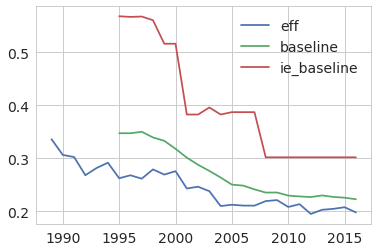

In [208]:
#CIT
name2iso2 = {'Oman': 'OM', 'Korea (Dem. Rep.)': 'KP', 'Micronesia, Federated States of': 'FM', "Korea (Dem. People's Rep.)": 'KP', 'Democratic Republic of Congo': 'CD', 'Lebanon': 'LB', 'Greenland': 'GL', 'Dominican Republic': 'DO', 'Estonia': 'EE', 'Slovak Rep.': 'SK', 'Namibia': 'NA', 'Botswana': 'BW', 'Sierra Leone': 'SL', 'Brunei Darussalam': 'BN', 'Isle of Man': 'IM', 'Equatorial Guinea': 'GQ', 'Belarus': 'BY', 'Quebec (Canada)': 'CA', 'Timor-Leste': 'TL', 'WAEC': '', 'Canada (see also Quebec)': 'CA', 'Macao SAR, China': 'MO', 'Georgia': 'GE', 'USSR': '', 'Macedonia, FYR': 'MK', 'Afghanistan': 'AF', 'Zambia': 'ZM', 'Falkland Islands': 'FK', 'Tanzania, United Republic of': 'TZ', 'Niue': 'NU', 'Venezuela, República Bolivariana de': 'VE', 'Congo, the Democratic Republic of the': 'CD', 'Spain': 'ES', 'Union of Soviet Socialist Republics': '', 'Jordan': 'JO', 'Saint Barthélemy': 'BL', 'Taiwan Province of China': 'TW', 'Antarctica': 'AQ', 'South Georgia and the South Sandwich Islands': 'GS', 'Nepal': 'NP', 'Congo, Democratic Republic of': 'CD', 'Virgin Islands, U.S.': 'VI', 'Bermuda': 'BM', 'Gabon': 'GA', 'O.C.A.M.': '', 'Réunion': 'RE', 'Venezuela, Bolivarian Republic of': 'VE', 'South Korea': 'KR', 'Faroe Islands': 'FO', 'CEMAC Treaty': ('AO', 'BI', 'CM', 'CF', 'TD', 'CD', 'GQ', 'GA', 'CG', 'RW', 'ST'), 'Rwanda': 'RW', 'North Korea': 'KP', 'Tokelau Islands': 'TK', 'WEAMU': ('AO', 'BI', 'CM', 'CF', 'TD', 'CD', 'GQ', 'GA', 'CG', 'RW', 'ST'), 'China, P.R.: Mainland': 'CN', 'United States Minor Outlying Islands': 'UM', 'CEMAC': ('AO', 'BI', 'CM', 'CF', 'TD', 'CD', 'GQ', 'GA', 'CG', 'RW', 'ST'), 'Moldova, Republic of': 'MD', 'Congo, Rep.': 'CG', "Cote d'Ivoire": 'CI', 'Saint Pierre and Miquelon': 'PM', 'Malta': 'MT', 'Viet Nam': 'VN', 'Palestine': 'PS', 'Algeria': 'DZ', 'Peru': 'PE', 'Bouvet Island': 'BV', 'Armenia, Republic of': 'AM', 'Sint Maarten': 'SX', 'Korea, Republic of': 'KR', 'Zimbabwe': 'ZW', 'Moldova': 'MD', 'Guam': 'GU', "Korea, Democratic People's Rep. of": 'KP', 'Mexico': 'MX', 'Mongolia': 'MN', 'Congo (Dem. Rep.)': 'CD', 'Tunisia': 'TN', 'Brunei': 'BN', 'Somalia': 'SO', 'US Pacific Islands': 'UM', 'Palestine, State of': 'PS', 'The Bahamas': 'BS', 'Belgium': 'BE', 'Netherlands': 'NL', 'Brazil': 'BR', 'Liberia': 'LR', 'Congo, Republic of': 'CG', 'Papua New Guinea': 'PG', 'Turkey': 'TR', 'Central African Republic': 'CF', 'French Southern Territories': 'TF', 'Kyrgyzstan': 'KG', 'Suriname': 'SR', 'El Salvador': 'SV', 'Lithuania': 'LT', 'Palau': 'PW', 'Marshall Islands': 'MH', 'New Caledonia': 'NC', 'Nauru': 'NR', 'South Sudan': 'SS', 'Czech Republic': 'CZ', 'China (People’s Rep.)': 'CN', 'Slovakia': 'SK', 'Mauritania': 'MR', 'Western Sahara': 'EH', 'Japan': 'JP', 'Svalbard and Jan Mayen': 'SJ', 'Cuba': 'CU', 'Uzbekistan': 'UZ', 'Serbia': 'RS', 'Maldives': 'MV', 'France': 'FR', 'Falkland Islands (Malvinas)': 'FK', 'Ghana': 'GH', 'United States': 'US', 'Grenada': 'GD', 'Mauritius': 'MU', 'Arab Economic Council': ('DZ', 'BH', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM', 'PS', 'QA', 'SA', 'SD', 'SY', 'TN', 'AE', 'YE'), 'Holy See (Vatican City State)': 'VA', 'Azerbaijan': 'AZ', 'Jersey, Channel Islands': 'JE', 'India': 'IN', 'St. Vincent and the Grenadines': 'VC', 'Russia': 'RU', 'Mozambique': 'MZ', 'Tonga': 'TO', 'Bolivia, Plurinational State of': 'BO', 'Curacao': 'CW', 'Bhutan': 'BT', 'Guadeloupe': 'GP', 'Timor-Leste, Dem. Rep. of': 'TL', 'Jamaica': 'JM', 'South Georgia and Sandwich Islands': 'GS', 'Northern Mariana Isl': 'MP', 'Bonaire, Sint Eustatius and Saba': 'BQ', 'Bahrain': 'BH', 'Tuvalu': 'TV', 'Kosovo': 'XK', 'Hong Kong SAR, China': 'HK', 'Macedonia, the Former Yugoslav Republic of': 'MK', 'Nigeria': 'NG', 'Vanuatu': 'VU', 'Armenia': 'AM', 'Liechtenstein': 'LI', 'Germany': 'DE', 'Libya': 'LY', 'Ecuador': 'EC', 'Dominica': 'DM', 'UDEAC': ('AO', 'BI', 'CM', 'CF', 'TD', 'CD', 'GQ', 'GA', 'CG', 'RW', 'ST'), 'Honduras': 'HN', 'Comoros': 'KM', 'Iran': 'IR', 'Morocco': 'MA', 'Reunion': 'RE', 'Gambia, The': 'GM', 'French Polynesia': 'PF', 'Iraq': 'IQ', 'Uruguay': 'UY', 'Lao PDR': 'LA', 'Guinea-Bissau': 'GW', 'Burma': 'MM', 'Slovak Republic': 'SK', 'Djibouti': 'DJ', 'Taiwan': 'TW', 'Macedonia': 'MK', 'Russian Federation': 'RU', 'Norway': 'NO', 'Cabo Verde': 'CV', 'Ivory Coast': 'CI', 'Bolivia': 'BO', 'Saint Kitts and Nevis': 'KN', 'St Maarten': 'SX', 'Trinidad and Tobago': 'TT', 'Gibraltar': 'GI', 'Israel': 'IL', 'Solomon Islands': 'SB', 'Syria': 'SY', 'Latvia': 'LV', 'Yemen, Rep.': 'YE', 'Macedonia (FYR)': 'MK', 'Kosovo, Republic of': 'XK', 'West African Economic and Monetary Union': ('BJ', 'BF', 'CI', 'GW', 'ML', 'NE', 'SN', 'TG'), 'Andorra': 'AD', 'Wallis and Futuna': 'WF', 'Sri Lanka': 'LK', 'Guiana, French': 'GY', 'Ukraine': 'UA', 'Denmark': 'DK', 'Bonaire, Saint Eustatius and Saba': 'BQ', 'Samoa': 'WS', 'Costa Rica': 'CR', 'Burkina Faso': 'BF', 'St. Martin': 'MF', 'Curaçao': 'CW', 'St. Martin (French part)': 'MF', 'Economic Community of West African States': ('BJ', 'BF', 'CV', 'GM', 'GH', 'GN', 'GW', 'CI', 'LR', 'ML', 'NE', 'NG', 'SN', 'SL', 'TG'), 'Poland': 'PL', 'Puerto Rico': 'PR', 'Sint Maarten (Dutch part)': 'SX', 'Northern Mariana Islands': 'MP', 'Iran, Islamic Republic of': 'IR', 'Greece': 'GR', 'The Gambia': 'GM', 'US Virgin Islands': 'VI', 'French Territories: French Polynesia': 'PF', 'Arab Maghreb Union': ('DZ', 'LY', 'MR', 'MA', 'TN'), 'Turks and Caicos Islands': 'TC', 'West Bank and Gaza': 'PS', 'Italy': 'IT', 'Korea, Rep.': 'KR', 'Congo': 'CG', 'Yemen, Republic of': 'YE', 'Nicaragua': 'NI', 'Serbia, Republic of': 'RS', 'Thailand': 'TH', 'Saint Helena': 'SH', 'Congo (Rep.)': 'CG', 'Cape Verde': 'CV', 'Macao': 'MO', 'Bahamas': 'BS', 'British Virgin Islands': 'VG', 'Pakistan': 'PK', 'Egypt': 'EG', 'CARICOM': ('AG', 'BS', 'BB', 'BZ', 'DM', 'GD', 'GY', 'HT', 'JM', 'MS', 'KN', 'LC', 'VC', 'SR', 'TT', 'AI', 'BM', 'VG', 'KY', 'TC'), 'Cayman Islands': 'KY', 'Argentina': 'AR', 'South Africa': 'ZA', 'Fiji': 'FJ', "Lao People's Democratic Republic": 'LA', 'Aruba': 'AW', "Korea, Democratic People's Republic of": 'KP', 'Saudi Arabia': 'SA', 'Jersey': 'JE', 'Cambodia': 'KH', 'Virgin Islands (U.S.)': 'VI', 'Paraguay': 'PY', 'Saint Lucia': 'LC', 'Indonesia': 'ID', 'Marshall Islands, Republic of': 'MH', 'Cook Islands': 'CK', 'Turkmenistan': 'TM', 'Kuwait': 'KW', 'Montenegro': 'ME', 'Kyrgyz Republic': 'KG', 'Seychelles': 'SC', 'Christmas Island': 'CX', 'Portugal': 'PT', 'Sweden': 'SE', 'French Territories: New Caledonia': 'NC', 'Australia': 'AU', 'St. Pierre and Miquelon': 'PM', 'Hungary': 'HU', 'Saint Vincent and the Grenadines': 'VC', 'China': 'CN', 'Eritrea': 'ER', 'Belize': 'BZ', 'Finland': 'FI', 'Tanzania': 'TZ', 'Laos': 'LA', 'Swaziland': 'SZ', 'Saint Helena, Ascension and Tristan da Cunha': 'SH', 'United Kingdom': 'GB', 'Egypt, Arab Rep.': 'EG', 'Iceland': 'IS', 'Azerbaijan, Republic of': 'AZ', 'Venezuela': 'VE', 'Taiwan, Province of China': 'TW', 'Bahrain, Kingdom of': 'BH', 'Togo': 'TG', 'New Zealand': 'NZ', 'St. Lucia': 'LC', 'Vietnam': 'VN', 'Bosnia and Herzegovina': 'BA', 'Antigua and Barbuda': 'AG', 'Virgin Islands, British': 'VG', 'Canada': 'CA', 'British Indian Ocean Territory': 'IO', 'Tajikistan': 'TJ', 'Anguilla': 'AI', 'Cocos (Keeling) Islands': 'CC', 'Guyana': 'GY', 'Pitcairn': 'PN', 'Sao Tome and Principe': 'ST', 'Lesotho': 'LS', 'Haiti': 'HT', 'Philippines': 'PH', 'Germany (until 1990 former territory of the FRG)': 'DE', "China (People's Rep.)": 'CN', 'Chad': 'TD', 'WAEMU': ('BJ', 'BF', 'CI', 'GW', 'ML', 'NE', 'SN', 'TG'), 'Congo, Dem. Rep.': 'CD', 'China, P.R.: Hong Kong': 'HK', 'Iran, Islamic Rep.': 'KP', 'Korea, Dem. People���s Rep.': 'KP', 'Croatia': 'HR', 'Tokelau': 'TK', 'Guernsey': 'GG', 'Slovenia': 'SI', 'Mali': 'ML', 'Kiribati': 'KI', 'Gambia': 'GM', 'Colombia': 'CO', "Côte d'Ivoire": 'CI', 'Ethiopia': 'ET', 'Angola': 'AO', 'Mayotte': 'YT', 'Myanmar': 'MM', 'Bahamas, The': 'BS', 'French Guiana': 'GF', 'Benin': 'BJ', "China People's Rep.": 'CN', 'Malaysia': 'MY', 'Bangladesh': 'BD', 'Vatican': 'VA', 'Economic and Monetary Community of Central Africa': ('AO', 'BI', 'CM', 'CF', 'TD', 'CD', 'GQ', 'GA', 'CG', 'RW', 'ST'), 'São Tomé and Príncipe': 'ST', 'Monaco': 'MC', 'Korea, Dem. Rep.': 'KP', 'Kazakhstan': 'KZ', 'Malawi': 'MW', 'Chile': 'CL', 'Hong Kong SAR': 'HK', 'Singapore': 'SG', 'Congo (Democratic Republic)': 'CD', 'Channel Islands': 'JE', 'OCAM': '', 'Montserrat': 'MS', 'Pitcairn Islands': 'PN', 'Switzerland': 'CH', 'Heard Island and McDonald Islands': 'HM', 'Sudan': 'SD', 'Cameroon': 'CM', 'St. Kitts and Nevis': 'KN', 'Arab Economic Union Council': ('DZ', 'BH', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM', 'PS', 'QA', 'SA', 'SD', 'SY', 'TN', 'AE', 'YE'), 'Senegal': 'SN', 'Bulgaria': 'BG', 'Hong Kong': 'HK', 'Luxembourg': 'LU', 'Czech Rep.': 'CZ', 'Serbia and Montenegro': 'RS', 'Cyprus': 'CY', 'Netherlands Antilles': 'CW', 'Syrian Arab Republic': 'SY', 'Uganda': 'UG', 'Romania': 'RO', 'Barbados': 'BB', 'Yemen': 'YE', 'Quebec': 'CA', 'Panama': 'PA', 'Taiwan, China': 'TW', 'Albania': 'AL', 'United Arab Emirates': 'AE', 'Afghanistan, Islamic Republic of': 'AF', 'Norfolk Island': 'NF', 'Democratic Republic of the Congo': 'CD', 'Niger': 'NE', 'Martinique': 'MQ', 'San Marino': 'SM', 'Faeroe Islands': 'FO', 'Qatar': 'QA', 'Guinea': 'GN', 'Venezuela, RB': 'VE', 'Åland Islands': 'AX', 'Ireland': 'IE', 'Saint Martin (French part)': 'MF', 'Madagascar': 'MG', 'American Samoa': 'AS', 'Republic of Congo': 'CG', 'Republic of the Congo': 'CG', 'Burundi': 'BI', 'China, P.R.: Macao': 'MO', 'Micronesia, Fed. Sts.': 'FM', 'Guatemala': 'GT', 'Micronesia': 'FM', 'Macau': 'MO', 'Korea (Rep.)': 'KR', 'Kenya': 'KE', 'Austria': 'AT'}
cit = pd.read_excel("../race_to_the_bottom/data/taxation_trends_2017_statutory-tax-rates.xls",sheet_name=2,skiprows=4,skip_footer=33)
cit = pd.melt(cit,id_vars = ["Unnamed: 1"], value_vars=list(range(1995,2018)),var_name="year",value_name="tax")
cit["iso2"] = cit["Unnamed: 1"].map(name2iso2)
cit["year"] = cit["year"].astype(int)
cit.loc[cit["iso2"]=="LU","tax"] -= 6.75
cit = cit.loc[:,["iso2","year","tax"]]
cit = cit.loc[(cit["year"]>1988)&(cit["year"]<2017)]
cit["tax"] /= 100

x = all_data.loc[(all_data["iso2"].isin(EU))&(all_data["cons"]==1)&(all_data["mult"]==1)]
x = x.loc[(x["year"]>1988)&(x["year"]<2017)]

x = pd.merge(x,cit,how="outer")
y = x.copy()
y = y.loc[y["iso2"]=="DE"].sort_values(by='year')
x = x.groupby("year").mean()[["tax_rate_wmean","tax"]].reset_index()

x.head()

plt.plot(x["year"],x["tax_rate_wmean"],label="eff")
plt.plot(x["year"],x["tax"],label="baseline")
plt.plot(y["year"],y["tax"],label="ie_baseline")
plt.legend()

In [225]:
all_data = pd.concat([tax_year_profits(tax_data,consCode=consCode,mult=mult).reset_index() 
                              for consCode in ["C","U"] 
                              for mult in range(3)])
all_data = all_data.replace([np.inf,-np.inf],np.NaN)
all_data.to_csv("data/all_data.tsv",index=None,sep="\t")
all_data.head()

C 0 ['iso2', 'year']
C 1 ['iso2', 'year']
C 2 ['iso2', 'year']
U 0 ['iso2', 'year']


/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


U 1 ['iso2', 'year']
U 2 ['iso2', 'year']


,iso2,year,tax_rate_mean,tax_rate2_mean,tfa_wages_mean,ifa_wages_mean,cash_wages_mean,loans_wages_mean,capital_wages_mean,interestPaid_wages_mean,...,cash_wages_wcount,loans_wages_wcount,capital_wages_wcount,interestPaid_wages_wcount,RDexpenses_wages_wcount,profit_rate_rev_wcount,profit_rate_emp_wcount,zero_profits,mult,cons
0,AD,2013,0.093817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,1
1,AD,2014,0.088203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,1
2,AD,2015,0.057307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,1
3,AD,2016,0.098012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,1
4,AE,1998,0.023718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [211]:
all_data.loc[(all_data["iso2"]=="LU")&(all_data["cons"]==0)&(all_data["year"]>2007),["year","cons","mult","tax_rate_median","profit_rate_rev_median","profit_rate_emp_median"]].groupby("mult").mean()

,year,cons,tax_rate_median,profit_rate_rev_median,profit_rate_emp_median
mult,,,,,
0,2012.5,0.0,0.144014,0.252773,0.695663
1,2012.5,0.0,0.057674,0.404261,3.041845
2,2012.5,0.0,0.014200,1.360351,7.150378


In [219]:
all_data.loc[(all_data["iso2"]=="ES")&(all_data["cons"]==0)&(all_data["year"]>2007),["year","cons","mult","tax_rate_median","profit_rate_rev_median","profit_rate_emp_median"]].groupby("mult").mean()

,year,cons,tax_rate_median,profit_rate_rev_median,profit_rate_emp_median
mult,,,,,
0,2012.5,0.0,0.264126,0.219899,1.651955
1,2012.5,0.0,0.280479,0.118489,0.768647
2,2012.5,0.0,0.263117,0.150573,1.046342


In [221]:
all_data.loc[(all_data["iso2"]=="NL")&(all_data["cons"]==0)&(all_data["year"]>2007),["year","cons","mult","tax_rate_median","profit_rate_rev_median","profit_rate_emp_median"]].groupby("mult").mean()

,year,cons,tax_rate_median,profit_rate_rev_median,profit_rate_emp_median
mult,,,,,
0,2012.5,0.0,0.240286,0.146719,0.652093
1,2012.5,0.0,0.212080,0.135176,0.817191
2,2012.5,0.0,0.240843,0.101523,0.704905


In [ ]:
all_data_sector = pd.concat([tax_year_profits(tax_data,consCode=consCode,mult=mult,groupby=["iso2","year","letterNACE"]).reset_index() 
                              for consCode in ["C","U"] 
                              for mult in range(3)])
all_data_sector = all_data_sector.replace([np.inf,-np.inf],np.NaN)
all_data_sector.to_csv("data/all_data_sector.tsv",index=None,sep="\t")
all_data_sector.head()

In [ ]:
data_size1 = pd.concat([tax_year_profits(tax_data,consCode=consCode,mult=mult,groupby=["iso2","year","group_size_ass"]).reset_index() 
                              for consCode in ["C"] 
                              for mult in range(3)])
data_size2 = pd.concat([tax_year_profits(tax_data,consCode=consCode,mult=mult,groupby=["iso2","year","group_size_ass_u"]).reset_index() 
                              for consCode in ["U"] 
                              for mult in range(3)])
all_data_size = pd.concat([data_size1,data_size2])
all_data_size = all_data_size.replace([np.inf,-np.inf],np.NaN)
all_data_size.to_csv("data/all_data_size.tsv",index=None,sep="\t")
all_data_size.head()

In [126]:
tax_data.columns

Index(['BvD', 'consolidationCode', 'year', 'operatingRevenue', 'PLbeforeTax',
       'Taxation', 'PLafterTax', 'deferredTaxes', 'coreNACE', 'entityType',
       'fixedAssets', 'tangibleFixedAssets', 'numberEmployees', 'loans',
       'retainedEarnings', 'incomeTaxPayable', 'companyName', 'city', 'iso2',
       'keepForm', 'standardisedLegalForm', 'status', 'guo', 'iso2_guo',
       'multinat', 'intangibleFA', 'tangibleFA', 'otherFA', 'cash', 'capital',
       'costEmployees', 'depreciation_amortization', 'interestPaid',
       'RDexpenses', 'deferredTaxes_new', 'group_size_rev', 'group_size_ass',
       'group_size_rev_u', 'group_size_ass_u', 'letterNACE'],
      dtype='object')

In [125]:
tax_data.loc[tax_data["iso2"]=="DK"].sort_values(by="p")

,BvD,consolidationCode,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,entityType,...,costEmployees,depreciation_amortization,interestPaid,RDexpenses,deferredTaxes_new,group_size_rev,group_size_ass,group_size_rev_u,group_size_ass_u,letterNACE
16032700,DK00323SD,C1,1984,8.524818e+08,49297723.0,17579140,31448001.0,NaN,1081.0,NaN,...,58057824.0,22197266.0,36866533.0,0.0,NaN,9.0,9.0,-9.0,-9.0,C
16032701,DK00323SD,C1,1985,8.211106e+08,30132060.0,11711456,18021403.0,NaN,1081.0,NaN,...,50938720.0,27192628.0,43737743.0,0.0,NaN,9.0,9.0,-9.0,-9.0,C
16032702,DK00323SD,C1,1986,1.016610e+09,25732524.0,-1634519,27160108.0,NaN,1081.0,NaN,...,358345976.0,27933103.0,51646896.0,0.0,NaN,9.0,9.0,-9.0,-9.0,C
16032703,DK00323SD,C1,1987,1.082853e+09,47376327.0,21952299,25423582.0,NaN,1081.0,NaN,...,66217548.0,30944794.0,49094582.0,0.0,NaN,9.0,9.0,-9.0,-9.0,C
16032704,DK00323SD,C1,1988,1.054793e+09,75233189.0,30990305,41235671.0,28030243.0,1081.0,NaN,...,58261486.0,24344307.0,35618553.0,21338749.5,28030243.0,9.0,9.0,-9.0,-9.0,C
16032705,DK10000025,U1,2001,NaN,-33000.0,0,NaN,NaN,9499.0,C,...,9700.0,9900.0,NaN,NaN,NaN,-9.0,-9.0,4.0,6.0,S
16032706,DK10000025,U1,2002,NaN,-28000.0,0,NaN,NaN,9499.0,C,...,13300.0,11700.0,NaN,NaN,NaN,-9.0,-9.0,4.0,6.0,S
16032707,DK10000025,U1,2003,NaN,-38000.0,0,NaN,NaN,9499.0,C,...,14800.0,13900.0,NaN,NaN,NaN,-9.0,-9.0,4.0,6.0,S
16032708,DK10000025,U1,2004,NaN,-58000.0,0,NaN,NaN,9499.0,C,...,16100.0,17000.0,NaN,NaN,NaN,-9.0,-9.0,4.0,6.0,S
16032709,DK10000025,U1,2005,NaN,296000.0,-4700,NaN,NaN,9499.0,C,...,35000.0,8700.0,NaN,NaN,NaN,-9.0,-9.0,4.0,6.0,S


In [ ]:
tax_data_groupped_c = tax_data.loc[(tax_data["consolidationCode"].str[0]=="C")].groupby(["BvD","iso2"]).sum()#.groupby("iso2").reset_index()

In [ ]:
np.percentile(tax_data["operatingRevenue"].dropna(),range(101))

In [119]:
tax_data_cons_mult_sector = tax_year_profits(tax_data,consCode="C",mult=True,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_cons_dome_sector = tax_year_profits(tax_data,consCode="C",mult=False,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_uncons_dome_sector = tax_year_profits(tax_data,consCode="U",mult=False,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_uncons_mult_sector = tax_year_profits(tax_data,consCode="U",mult=True,groupby=["iso2","year","letterNACE"]).reset_index()

all_data_sector = pd.concat([tax_data_uncons_mult_sector,tax_data_cons_mult_sector,tax_data_uncons_dome_sector,tax_data_cons_dome_sector])
all_data_sector.to_csv("data/all_data_sector.tsv",index=None,sep="\t")
all_data_sector.head()

,iso2,year,letterNACE,profit_rate_mean,tax_rate_mean,profit_rate_median,tax_rate_median,profit_rate_std,tax_rate_std,profit_rate_count,tax_rate_count,profit_rate_wmean,tax_rate_wmean,profit_rate_wstd,tax_rate_wstd,zero_profits,mult,cons
0,AE,1994,J,0.773482,0.552915,0.773482,0.552915,NaN,NaN,1.0,1.0,0.773482,0.552915,0.0,0.0,0.0,1,0
1,AE,1995,J,0.788610,0.565175,0.788610,0.565175,NaN,NaN,1.0,1.0,0.788610,0.565175,0.0,0.0,0.0,1,0
2,AE,1996,J,0.790291,0.562731,0.790291,0.562731,NaN,NaN,1.0,1.0,0.790291,0.562731,0.0,0.0,0.0,1,0
3,AE,1998,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.120047,0.255983,0.0,0.0,0.0,1,0
4,AE,1999,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0


In [8]:
all_data = pd.read_csv("data/all_data.tsv",index_col=None,sep="\t")

# Make some plotsm

In [ ]:
number_countries = len(all_data["iso2"].unique())
number_countries

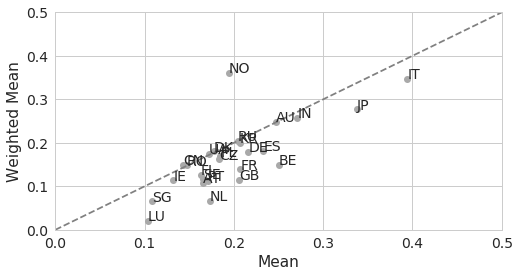

In [292]:
#Big companies pay less tax (compare mult 1 to mult 0)
all_datax = all_data.loc[all_data["tax_rate_count"]>1000]
all_datax = all_datax.loc[all_datax["cons"]==0]
all_datax = all_datax.loc[all_datax["mult"]==1]
all_datax = all_datax.groupby("iso2").mean().reset_index()

plt.figure(figsize=(8,4))
for c,x,y in zip(all_datax["iso2"],all_datax["tax_rate_mean"],all_datax["tax_rate_wmean"]):
    plt.annotate(c,(x,y),fontsize=14)
    plt.scatter(x,y,color="darkgray",lw=0)

plt.xlabel("Mean")
plt.ylabel("Weighted Mean")
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.plot([0,0.5],[0,0.5],"--",color="gray")

In [29]:
nl = tax_data.loc[(tax_data["iso2"].isin(["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]))&
                  (tax_data["consolidationCode"].str[0]!="C")&(tax_data["year"]==2011)]
nl["PLbeforeTax"] = np.log10(nl["PLafterTax"])
nl["Taxation"] = np.log10(nl["Taxation"])
nl = nl.loc[nl["PLbeforeTax"]>0]
nl = nl.loc[nl["Taxation"]>0]

In [248]:
tax_data_groupped = tax_data.loc[(tax_data["consolidationCode"].str[0]!="C")].groupby(["BvD","iso2"]).sum()#.groupby("iso2").reset_index()

In [250]:
for c,data in tax_data_groupped.groupby("iso2"):
    if c == "LU":
        data["ETR"] = data["Taxation"]/data["PLbeforeTax"]        
        data["PLbeforeTax"] = np.log10(data["PLafterTax"])
        data["Taxation"] = np.log10(data["Taxation"])
        
        data = data.loc[data["PLbeforeTax"]>0]
        data = data.loc[data["Taxation"]>0]
        
        nl_m = data.loc[data["multinat"]==True].replace([np.inf,-np.inf],np.NaN).dropna(subset=["PLbeforeTax","Taxation"])
        nl_d = data.loc[data["multinat"]==False].replace([np.inf,-np.inf],np.NaN).dropna(subset=["PLbeforeTax","Taxation"])
        print(sm.rlm("ETR~PLbeforeTax",data=nl_m).fit().summary())
        print(sm.rlm("ETR~PLbeforeTax",data=nl_d).fit().summary())
        

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/anaco

                    Robust linear Model Regression Results                    
Dep. Variable:                    ETR   No. Observations:                  308
Model:                            RLM   Df Residuals:                      306
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 24 Jul 2018                                         
Time:                        19:48:44                                         
No. Iterations:                    18                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3977      0.035     11.324      

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/anaco

AL 0.9898841457515484 0.9874320838305323 0.2245993252343173 0.2380511955999287
AR 0.916801504265206 0.9851366674662784 0.8055108521805829 0.4087111148627374
AT 0.9550806637175067 0.9747382874689442 0.4283239039280128 0.3399074265105508
AU 0.9879018490833261 0.992766528975288 0.3767823924391125 0.33240553265983014


/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/robust_linear_model.py:284: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/robust_linear_model.py:432: RuntimeWarning: invalid value encountered in double_scalars
  k = 1 + (self.df_model+1)/self.nobs * var_psiprime/m**2


BA 0.991647446379276 0.9972733871293318 0.08969006970337955 0.1009508751922705
BE 0.9425637028355011 0.9624785574051891 0.47827172082412317 0.5207551132995271
0.47827172082412317 -0.057436297164498974
0.5207551132995271 -0.037521442594810946


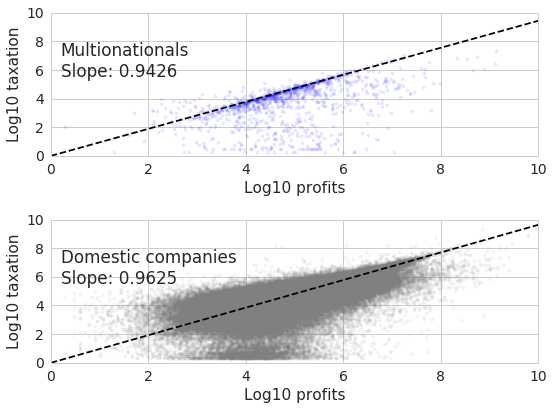

BG 0.9723337477139474 0.9872208544013877 0.23191826459798187 0.1666605191738143
BR 0.9073135050351991 0.9900014006839056 0.7782340897303935 0.2727714429720847
BY 0.9571860625437074 0.9133598732861725 0.46165129689153156 0.8581747450632318
CA 1.020200185824283 1.0048466729053669 0.1710528978317609 0.17077855958479948
CH 0.9484515489404262 0.9343099700080953 0.5638623843756496 0.7006444434320608
0.5638623843756496 -0.051548451059573806
0.7006444434320608 -0.06569002999190467


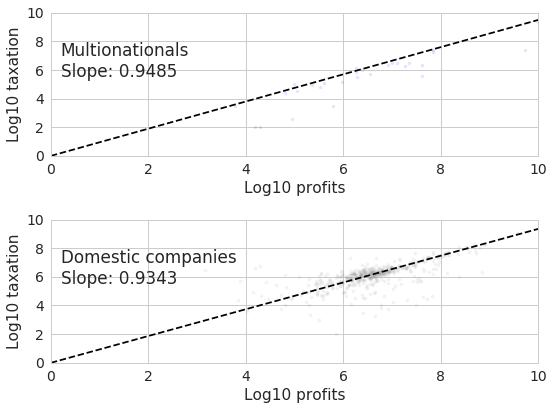

CL 0.9579023215270681 1.0164238083062636 0.5904091959450359 0.04283965395794129
CN 1.0100903523245401 1.0030758164034714 0.13915429989848094 0.15725761043536945
CO 0.9826461694863264 0.9948285245913897 0.3911691484261658 0.35727901126009537
CY 0.9823565941541311 0.96043230127544 0.18468595096876014 0.33880552616464255
CZ 0.9967700071411155 0.9935062131497764 0.2128208172809451 0.2359116182503521
DE 0.971046529221388 0.9939022879575863 0.3509498941032959 0.28205088680232143
DK 0.9845138492331306 0.9602046567223318 0.3053068709904925 0.4161919429590254
DZ 0.9519180677629885 0.9695217386141459 0.5611332194654789 0.36613941106627246
EC 0.8440617772253429 0.9475684915909477 1.217096410903755 0.6364753716234783
EE 0.976079700141264 0.9751080678171375 0.23206793408914891 0.2277441285976604
ES 0.9769377182143484 1.0029898998465427 0.31082487232980116 0.24341558612091058
FI 0.9605270968379704 0.9838573900326794 0.3722681103354014 0.3346018735471234
FR 1.0200514636052884 1.0415688629616386 0.136

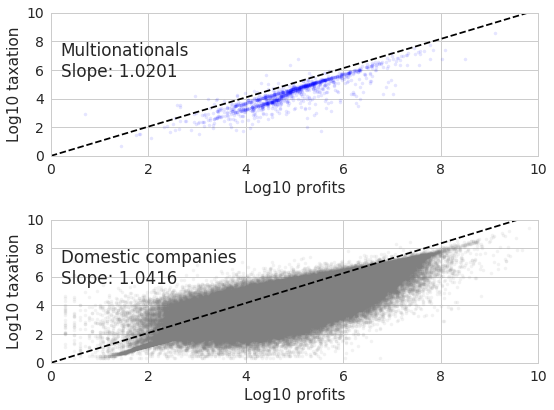

GB 0.9771554120920136 1.0127264695483547 0.3038459541400102 0.13124212356941095
GR 0.9686596925368954 0.9826285328444647 0.40722097400830504 0.37355109690986577
HK 0.9956646841930991 1.008014294565503 0.22519843543904683 0.13764326959755924
HR 0.9997958006956768 0.9970840815471848 0.2025760860566547 0.23120001226788184
HU 0.9948663480962749 0.9908234681304877 0.12050408740585891 0.17343665013835902
IE 0.9658658579095152 0.9949381069678254 0.3359148511850011 0.17038396416032012
0.3359148511850011 -0.034134142090484876
0.17038396416032012 -0.005061893032174587


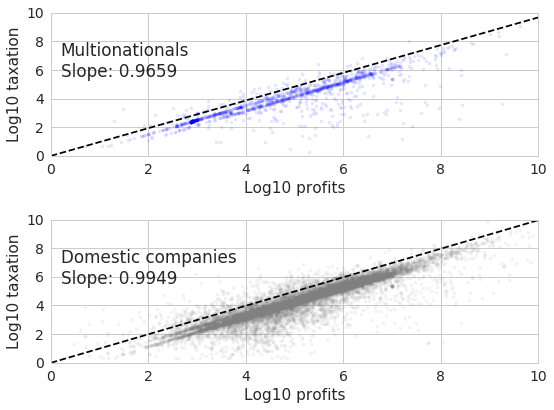

IL 1.0015362485514179 0.9851909805205477 0.19664374695936304 0.3399534806069471
IN 0.9790101042424705 0.9919515228032244 0.4069647751663489 0.3425399624935397
IR 0.9085858173512409 0.9819611734463639 0.7594595567334013 0.27336296784273784
IS 0.9858968791212749 0.9976472108965226 0.23586458797390242 0.19187940517289556
IT 0.9414872724648495 0.9542981820067648 0.6109012784613445 0.6663833968348376
JE 0.9404648422381304 0.9965065325258424 0.4650020821422658 0.24052458744311755
JM 1.1424225643958386 0.806233226812003 -0.9255157037363319 1.310021331879735
JP 0.9910357822857524 1.028710571757586 0.4312916216095951 0.13104254914797178
KR 0.987921016636841 1.0138380225593546 0.14076995095608627 0.047259121842377474
KY 0.8904505523608397 0.9872019687258589 1.0071599738652148 0.3280476313913734
KZ 0.9769030942800536 0.997397796520648 0.34163259259307877 0.216076138191214
LT 0.990016211172786 1.0071694279219692 0.17901870272969164 0.10727891013793235
LU 0.9530623028028882 0.9765110301787677 0.397

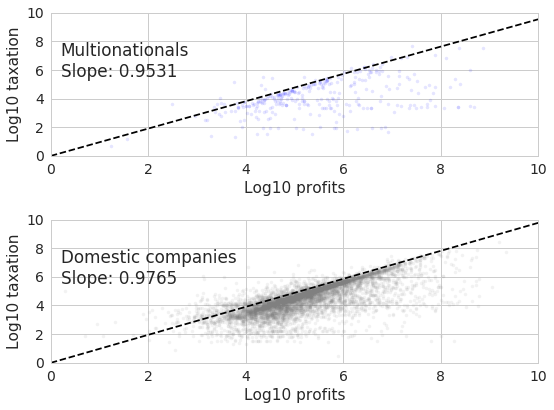

LV 0.9868496082774517 0.9346074941406696 0.20608521043529876 0.4792556546305694
MA 1.0214640069457717 1.0180963040141888 0.09570327521311882 0.09263237246871199


/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/robust_linear_model.py:171: RuntimeWarning: invalid value encountered in true_divide
  tmp_results.scale).sum()
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/norms.py:267: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)


ME 1.000307594781962 1.0004482221358808 0.09098985279745349 0.08590053793820296
MK 0.9765739622413896 1.010853884527341 0.18390122605770437 0.0029107579751483197
MT 0.980540171447702 0.9537412350719664 0.43410150110441587 0.5525814275216893
MU 0.9727917353270993 0.9917843206836275 0.30009899063695245 0.19836838039498544
MX 0.995319086076069 0.9609920398501473 0.3222965676004488 0.4598513882586655
MY 1.0113092990354184 0.9559159524315642 0.1924446380961118 0.4897908097544565
NL 0.9896568589599004 1.017417753209392 0.2695754564135474 0.12067141716295317
0.2695754564135474 -0.010343141040099611
0.12067141716295317 0.01741775320939193


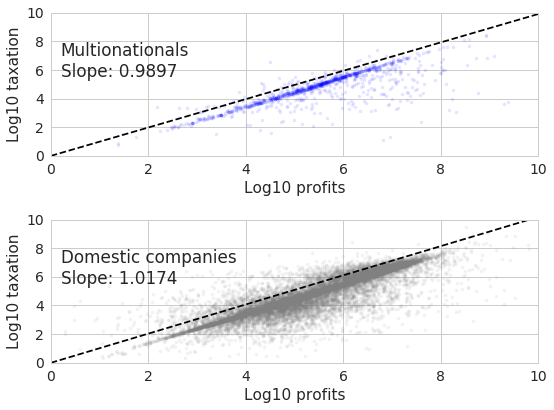

NO 0.9975343279997941 0.9734066288026322 0.25636124190928605 0.4108676528489716
NZ 0.9702046018687329 0.9769449187506032 0.3821518622568964 0.39832209596707435
PA 1.022859057691685 0.990705725818342 0.11566126077573272 0.29695793712413804
PE 0.9731302901907886 0.9894459977604173 0.4568414056408151 0.3674918948016905
PH 0.9239600955569877 0.9840510012107894 0.6819880118765506 0.3846024636131543
PL 0.9599383472437152 0.9941537307776429 0.3677366089709376 0.23499131420194502
PT 0.9865913851198727 0.9800906425308015 0.26224404006633967 0.3520811994575034
PY 0.9692767251039937 1.0047459403803 0.3468705460402311 0.08109171328839158
RO 0.9786432452513785 0.944622230498478 0.23297952771399022 0.42336257710225145
RS 0.9981000346304724 0.9928058099682068 0.1437598342821673 0.11773601336316047
RU 1.0124801707857436 0.9912782075024316 0.12446235669784553 0.19136455558077622
SE 0.9442600615354665 0.9732328958567077 0.43226793154421594 0.35803878423056446
SG 0.9479809949015466 0.9824204706459405 0.4

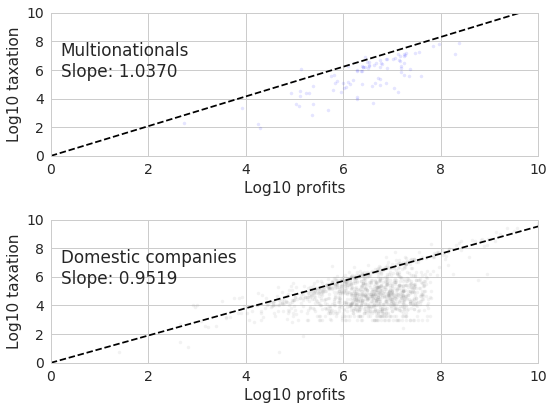

UY 0.9792921491255242 0.9521276496496729 0.34026569139300944 0.4753649694420215
VN 0.9721427796920376 0.9901471887049327 0.37671273355872326 0.26677680985042346


In [251]:
results = []
for c,data in tax_data_groupped.groupby("iso2"):
    data["ETR"] = data["Taxation"]/data["PLbeforeTax"]
    data["PLbeforeTax"] = np.log10(data["PLafterTax"])
    data["Taxation"] = np.log10(data["Taxation"])
    data = data.loc[data["PLbeforeTax"]>0]
    data = data.loc[data["Taxation"]>0]
    nl_m = data.loc[data["multinat"]==True].replace([np.inf,-np.inf],np.NaN).dropna(subset=["PLbeforeTax","Taxation"])
    nl_d = data.loc[data["multinat"]==False].replace([np.inf,-np.inf],np.NaN).dropna(subset=["PLbeforeTax","Taxation"])
 
    try:
        #slopem, interceptm, r_valuem, p_value, std_err = stats.linregress(nl_m["PLbeforeTax"],nl_m["Taxation"])
        interceptm,slopem = sm.rlm("ETR~PLbeforeTax",data=nl_m).fit().params.values
        #sloped, intercept, r_value, p_value, std_err = stats.linregress(nl_d["PLbeforeTax"],nl_d["Taxation"])
        interceptd,sloped = sm.rlm("ETR~PLbeforeTax",data=nl_d).fit().params.values
           
    except:
        continue
    print(c,1+slopem,1+sloped,interceptm,interceptd)
    results.append((c,slopem,sloped,interceptm,interceptd))
    if c in ["LU","NL","US","CH","IE","FR","BE"]:
        plt.figure(figsize=(8,6))

        ax = plt.subplot(2,1,1)
        ax.plot(nl_m["PLbeforeTax"],nl_m["Taxation"],".",color="b",alpha=0.1)
        interceptm,slopem = sm.rlm("ETR~PLbeforeTax",data=nl_m).fit().params.values
        print(interceptm,slopem)
        plt.plot([0,10],[0,0+10*(1+slopem)],"--",color="k")
        ax.annotate("Multionationals\nSlope: {:2.4f}".format(1+slopem),(0.2,5.5))
        
        plt.xlabel("Log10 profits")
        plt.ylabel("Log10 taxation")
        plt.xlim(0,10)
        plt.ylim(0,10)

        ax2 = plt.subplot(2,1,2)
        ax2.plot(nl_d["PLbeforeTax"],nl_d["Taxation"],".",color="gray",alpha=0.1)        
        interceptd,sloped = sm.rlm("ETR~PLbeforeTax",data=nl_d).fit().params.values
        print(interceptd,sloped)
        plt.plot([0,10],[0,0+10*(1+sloped)],"--",color="k")
        ax2.annotate("Domestic companies\nSlope: {:2.4f}".format(1+sloped),(0.2,5.5))
        plt.xlim(0,10)
        plt.ylim(0,10)
        plt.xlabel("Log10 profits")
        plt.ylabel("Log10 taxation")

        plt.tight_layout()
        plt.show()
        

In [213]:
iso22region = pd.read_csv("/datastore/shared/javier/interactive_visualizations/visualizations/data.pd",sep=",").set_index("iso2").to_dict()["region"]
region2color = {'EAS':"red", #East asia and pacific
                'ECS':"blue", #Europe and Central Asia
                'LCN':"orange", #Latin-America and caribbean
                'MEA':"green", #Middle East and north africa
                'NAC':"yellow", #North america
                'SAS':"gray", #south asia
                'SSF':"black"} #south saharian africa

Text(0.905,0.905,'Regressive for all')

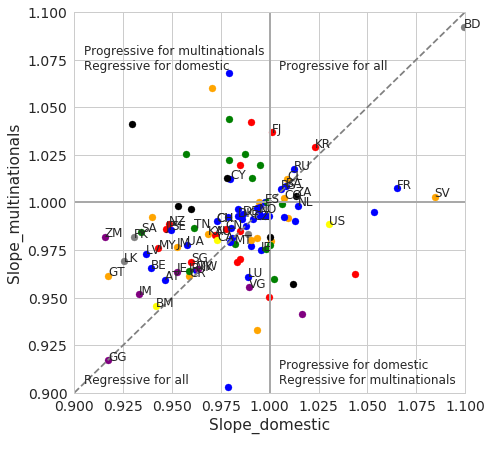

In [227]:
xm = 0.9
ym = 1.1
#r_fi = results.loc[results["r2_m"]>0.5]
#r_fi = r_fi.loc[r_fi["r2_d"]>0.5]
r_fi = pd.DataFrame(results,columns=["iso2","Slope_m","Slope_d","Intercept_m","Intercept_d"])
r_fi["Slope_d"] += 1
r_fi["Slope_m"] += 1
plt.figure(figsize=(7,7))
for c,x,y in zip(r_fi["iso2"],r_fi["Slope_d"],r_fi["Slope_m"]):
    try:
        col = region2color[iso22region[c]]
    except:
        col = "purple"
    if c in ["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]:
        plt.annotate(c,(x,y),fontsize=12)
    if (x > 1) and (y>1):
        plt.annotate(c,(x,y),fontsize=12)
    if (x < 0.975) and (y<0.99):
        plt.annotate(c,(x,y),fontsize=12)        
    plt.scatter(x,y,color=col)
plt.xlabel("Slope_domestic")
plt.ylabel("Slope_multinationals")
plt.xlim(xm,ym)
plt.ylim(xm,ym)
plt.plot([xm,ym],[xm,ym],"--",color="gray")
plt.plot([xm,ym],[1,1],color="darkgray",lw=2)
plt.plot([1,1],[xm,ym],color="darkgray",lw=2)

plt.annotate("Progressive for multinationals \nRegressive for domestic",(0.905,1.07),fontsize=12)
plt.annotate("Progressive for domestic \nRegressive for multinationals",(1.005,0.905),fontsize=12)
plt.annotate("Progressive for all",(1.005,1.07),fontsize=12)
plt.annotate("Regressive for all",(0.905,0.905),fontsize=12)


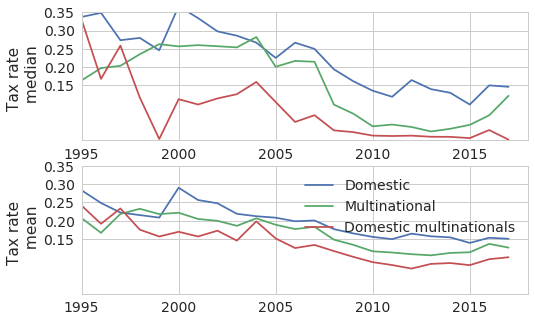

In [65]:
plt.figure(figsize=(8,8))

def plot_dom_mult(data,c,var="tax_rate_mean"):
    data = data.loc[(data["iso2"]==c)&(data["cons"]==0)]
    #data = data.loc[data["year"]>1990]
    dom = data.loc[data["mult"]==0]
    mult = data.loc[data["mult"]==1]
    dm = data.loc[data["mult"]==2]
    
    #plt.annotate(var,(1988,0.1))
    plt.plot(dom["year"],dom[var],label="Domestic")
    plt.ylim(0.0,0.35)
    plt.xlim(1995,2018)
    plt.plot(mult["year"],mult[var],label="Multinational")
    plt.plot(dm["year"],dm[var],label="Domestic multinationals")
    
    plt.ylabel("Tax rate \n {}".format(var.split("_")[-1]))
    plt.yticks([0.15,0.2,0.25,0.30,0.35])
    
plt.subplot(3,1,1)
plot_dom_mult(all_data,"LU","tax_rate_median")
plt.subplot(3,1,2)
plot_dom_mult(all_data,"LU","tax_rate_mean")
# plt.subplot(3,1,3)
# plot_dom_mult(all_data,"ES","tax_rate_wmean")
plt.legend()

#plt.title(var)

# Set the subplots to overlap
#plt.subplots_adjust(hspace=-.1)

# Remove axes details that don't play well with overlap
#plt.set_titles("")
#plt.yticks([])
#sns.despine(bottom=False, left=False)


plt.show()

In [151]:
def plot_violin(nl,th= 0):
    
    nl = nl.loc[nl["PLbeforeTax"]>th]
    nl["x"] = nl["Taxation"]/nl["PLbeforeTax"]

    nl = nl.loc[(nl["x"]>-.1)&(nl["x"]<0.5)]
    nl = nl.sort_values(by="iso2")
    
    plt.figure(figsize=(14,4))
    sns.violinplot(x="iso2",y="x",hue="multinat",split=True,data=nl,inner="quartile",palette="Set2")
    plt.ylabel("Tax rate")
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title="Multinational")
    plt.title("Threshold profits: {}".format(th))
    plt.show()

In [155]:
nl = tax_data.loc[(tax_data["iso2"].isin(["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]))&
                  (tax_data["consolidationCode"].str[0]!="C")&(tax_data["year"]==2011)]

nl_c = tax_data.loc[(tax_data["iso2"].isin(["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]))&
                  (tax_data["consolidationCode"].str[0]=="C")&(tax_data["year"]==2011)]



In [230]:
nl = tax_data.loc[(tax_data["iso2"].isin(["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]))&
                  (tax_data["consolidationCode"].str[0]!="C")].groupby(["BvD","iso2","multinat"]).sum().reset_index()

nl_c = tax_data.loc[(tax_data["iso2"].isin(["NL","LU","CH","IE","CZ","DK","ES","DE","US","CY","VG","MT","CN","NO"]))&
                  (tax_data["consolidationCode"].str[0]=="C")].groupby(["BvD","iso2","multinat"]).sum().reset_index()


CH


/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


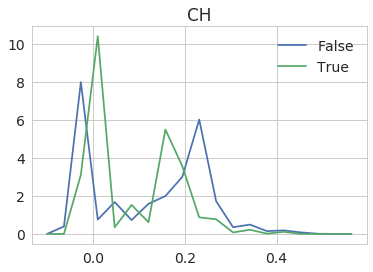

CN


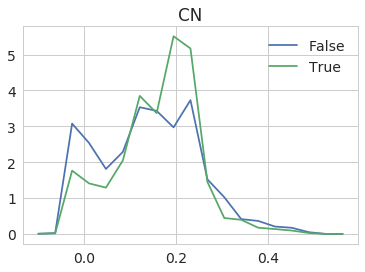

CY


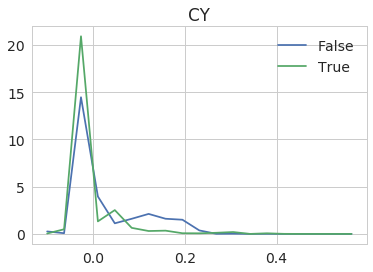

CZ


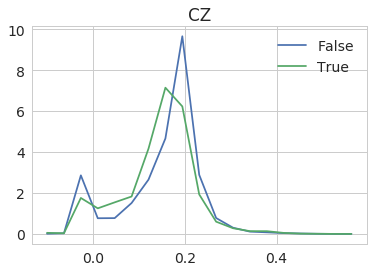

DE


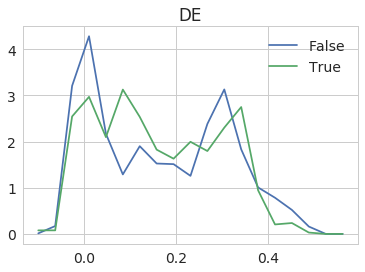

DK


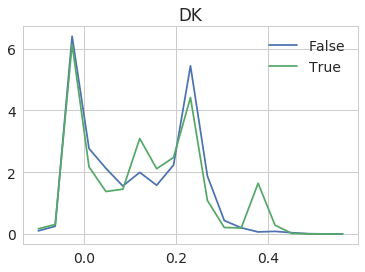

ES


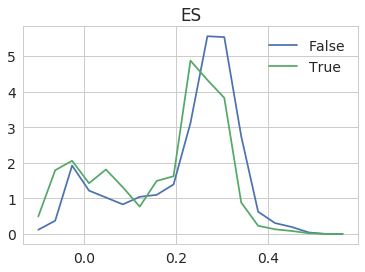

IE


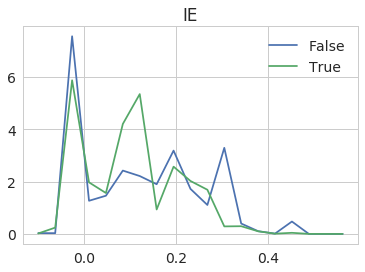

LU


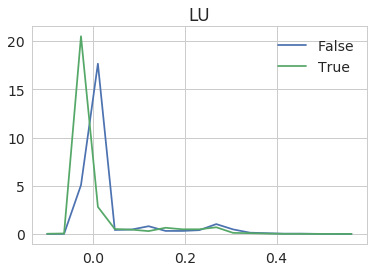

MT


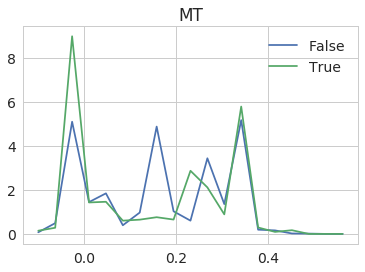

NL


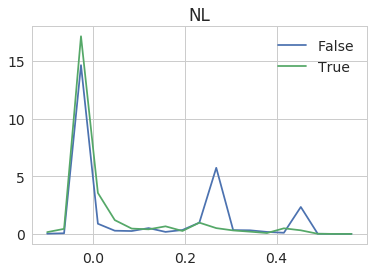

NO


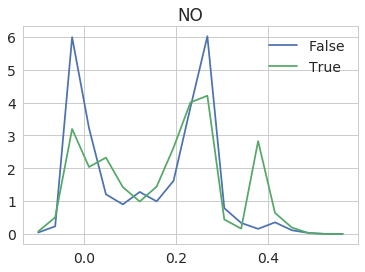

US


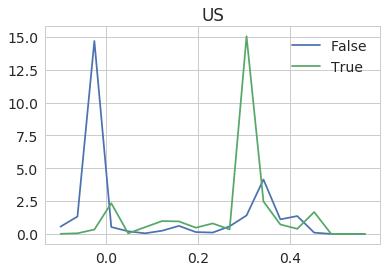

VG


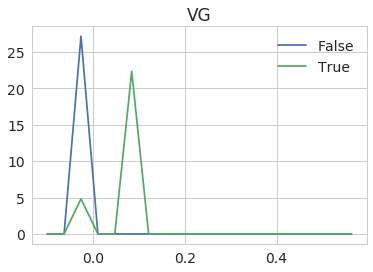

In [232]:

x = np.linspace(-0.1,0.6,20)
for country,data in nl.groupby("iso2"):
    print(country)
    for m,d in data.groupby("multinat"):
        d = d.loc[nl["PLbeforeTax"]>1E6]
        d["x"] = d["Taxation"]/d["PLbeforeTax"]
        #d["x"] = d["x"]*d["PLbeforeTax"]/np.sum(d["PLbeforeTax"])
        d = d.loc[(d["x"]>-.1)&(d["x"]<0.5)]
        d = d.sort_values(by="iso2")
    
        
        a,_ = np.histogram(d["x"], bins=x, density=True, weights=d["PLbeforeTax"])
        plt.plot(x[:-1],a,label=m)
        plt.legend()
        plt.title(country)
    plt.show()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


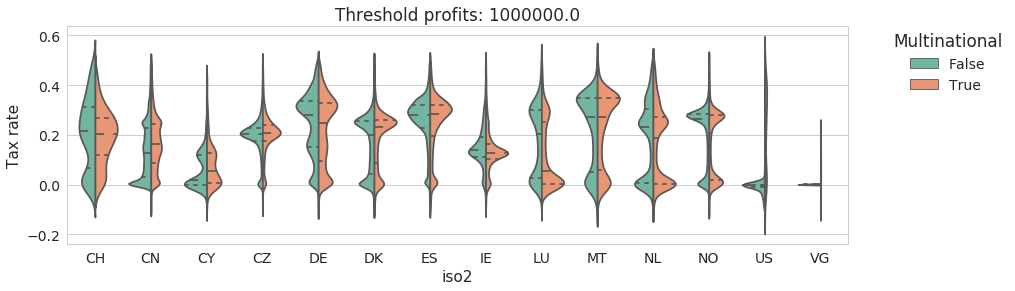

In [233]:
#Unconsolidated plots
plot_violin(nl,1E6)
#plot_violin(nl,0)

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


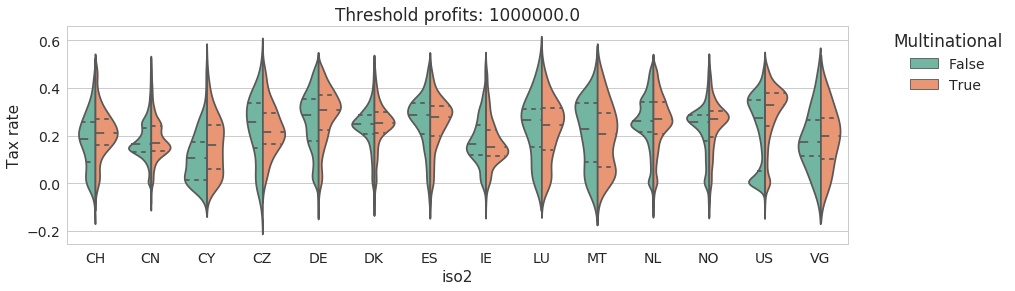

In [234]:
#Unconsolidated plots
plot_violin(nl_c,1E6)
#plot_violin(nl_c,0)

(2000, 2016)

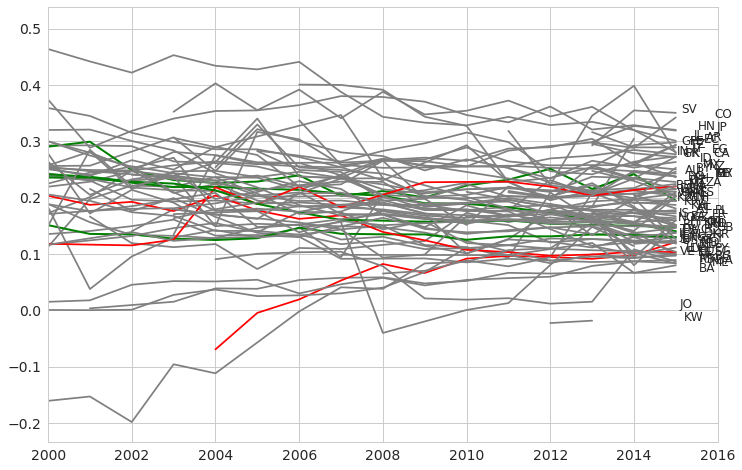

In [256]:
plt.figure(figsize=(12,8))
var = "tax_rate_mean"
for c,data in all_data.groupby("iso2"):
    data = data.sort_values(by="year")
    data = data.loc[data["tax_rate_count"]>10]
    data = data.loc[data["year"]<2016]
    data = data.loc[(data["cons"]==0)&(data["mult"]==1)]
    if len(data)>0:
        if c in ["IE","CH","NL","GB"]:
            plt.plot(data["year"],data[var],color="green",lw=2)
        elif c in ["LU","MT","CY"]:
            plt.plot(data["year"],data[var],color="red")
        else:
            plt.plot(data["year"],data[var],color="gray")
        ye = 2015+np.random.rand(1)
        plt.annotate(c,(ye,data[var].values[-1]),fontsize=12)
    else:
        pass#print(c)
plt.xlim(2000,2016)
#plt.yscale("log")

# By sector

In [155]:
tax_data_cons_mult_sector = tax_year_profits(tax_data,consCode="C",mult=True,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_cons_dome_sector = tax_year_profits(tax_data,consCode="C",mult=False,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_uncons_dome_sector = tax_year_profits(tax_data,consCode="U",mult=False,groupby=["iso2","year","letterNACE"]).reset_index()
tax_data_uncons_mult_sector = tax_year_profits(tax_data,consCode="U",mult=True,groupby=["iso2","year","letterNACE"]).reset_index()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


KeyboardInterrupt: 

In [457]:
data = pd.merge(tax_data_dome_sector,tax_data_uncons_mult_sector,on=["iso2","year","letterNACE"])
data = data.loc[(data["tax_rate_c_x"]>1)&(data["tax_rate_c_y"]>1)]
data["profit_diff"] = data["profit_rate_x"] - data["profit_rate_y"]
data["tax_diff"] = data["tax_rate_x"] - data["tax_rate_y"]
data["zero_profs"] = data["zero_profits_x"] - data["zero_profits_y"]
data = data.groupby(["iso2","letterNACE"]).mean().reset_index()
data = data.dropna()

In [459]:
df = data.loc[data["iso2"].isin(EU)].groupby("iso2").median()[["profit_diff","tax_diff"]].sort_values(by="profit_diff")
df = df*100
df.columns = ['Diff profit ratios','Diff tax rates']#,'Diff zero profit %']
df.tail(15)

,Diff profit ratios,Diff tax rates
iso2,,
CZ,2.688782,-1.905196
LV,3.406868,-1.345348
SE,3.425201,2.127448
ES,4.105015,0.373422
FR,4.165948,2.150692
SI,4.208128,0.859243
GR,4.481386,-2.862239
HR,4.725038,-0.765342
RO,5.251011,-0.435314


In [429]:
data.loc[data["iso2"]=="LU"]

,iso2,letterNACE,year,profit_rate_x,tax_rate_x,profit_rate_s_x,tax_rate_s_x,profit_rate_c_x,tax_rate_c_x,zero_profits_x,profit_rate_y,tax_rate_y,profit_rate_s_y,tax_rate_s_y,profit_rate_c_y,tax_rate_c_y,zero_profits_y,profit_diff,tax_diff,zero_profs
551,LU,C,2005.500000,inf,0.236931,17.293507,0.142732,10.590909,10.772727,0.222588,0.093411,0.175569,4.701892e+05,0.166065,34.863636,35.136364,0.222483,inf,0.061362,0.000106
552,LU,D,2008.266667,0.092780,0.199121,0.211453,0.108724,4.266667,4.266667,0.154847,0.150188,0.159661,6.496616e-01,0.128038,4.533333,4.533333,0.095505,-0.057408,0.039460,0.059342
553,LU,E,2011.500000,0.269533,0.280329,0.165150,0.101127,4.500000,4.500000,0.154902,0.116438,0.266241,3.646885e-02,0.090913,2.000000,2.000000,0.166667,0.153095,0.014088,-0.011765
554,LU,F,2006.000000,0.094573,0.306780,58.436722,0.128496,20.000000,20.333333,0.220982,0.131680,0.234560,3.324029e+00,0.168371,10.857143,11.095238,0.257378,-0.037107,0.072220,-0.036396
555,LU,G,2005.500000,0.069958,0.309842,12.715038,0.115656,23.954545,25.636364,0.222558,0.056641,0.296878,1.472192e+01,0.155387,40.000000,40.454545,0.202074,0.012420,0.012963,0.020484
556,LU,H,2010.818182,0.171576,0.218335,0.144574,0.112466,4.636364,4.636364,0.376108,0.075944,0.137354,1.166807e+01,0.168071,14.363636,14.363636,0.337248,0.095632,0.080981,0.038861
557,LU,I,2011.750000,0.182455,0.265114,0.195563,0.078878,2.625000,2.625000,0.419487,0.135183,0.243311,1.403909e-01,0.122806,3.750000,3.750000,0.272255,0.047272,0.021802,0.147233
558,LU,J,2009.000000,0.079234,0.247899,4.137830,0.128919,4.933333,5.000000,0.285001,0.176866,0.221784,2.799360e+01,0.176120,25.000000,25.000000,0.225251,-0.097632,0.026115,0.059750
560,LU,L,2009.500000,0.375753,0.224243,29.167256,0.132287,16.285714,16.714286,0.379843,1.404215,0.095641,7.536909e-01,0.149302,13.428571,13.642857,0.542239,-1.028461,0.128602,-0.162396
561,LU,M,2008.500000,0.225913,0.276467,27.779974,0.122769,8.062500,8.375000,0.240582,0.210786,0.151891,5.457382e+06,0.150928,14.875000,15.187500,0.283653,0.015127,0.124576,-0.043071


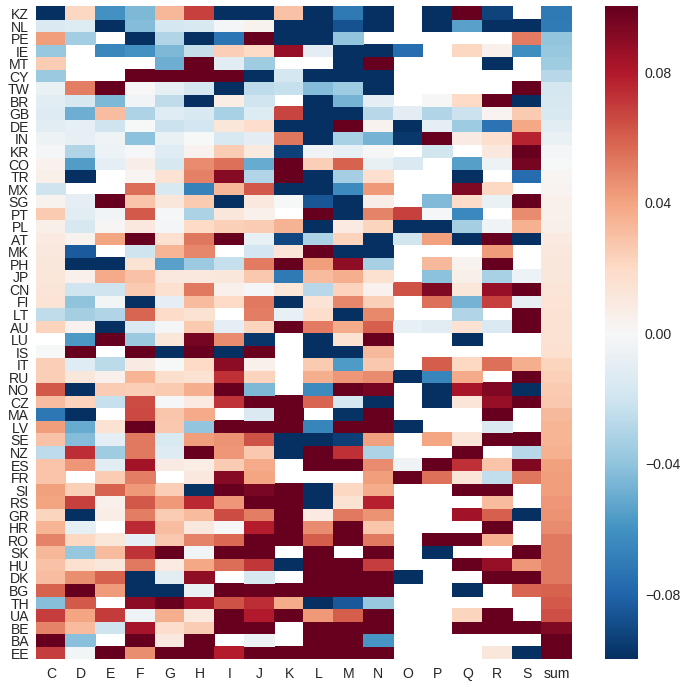

In [438]:
var = "profit_diff"
df = data[["iso2","letterNACE",var]]

df_fixed = df.pivot_table(var,
               "iso2",
               "letterNACE")
df_fixed = df_fixed.dropna(thresh=10)
df_fixed = df_fixed.dropna(thresh=10,axis=1)
df_fixed["sum"] = df_fixed.median(1)
df_fixed = df_fixed.sort_values(by="sum")
plt.figure(figsize=(12,12))
sns.heatmap(df_fixed.values,vmin=-0.1,vmax=0.1)
plt.yticks(0.5+np.arange(len(df_fixed.index)),[_ for _ in df_fixed.index][::-1],rotation=0)
plt.xticks(0.5+np.arange(len(df_fixed.columns)),[_ for _ in df_fixed.columns])

plt.show()

In [170]:
tax_data_uncons_mult["domestic"] = 0
tax_data_cons_mult["domestic"] = 0
tax_data_dome["domestic"] = 1

tax_data_uncons_mult["consolidated"] = 0
tax_data_cons_mult["consolidated"] = 1
tax_data_dome["consolidated"] = 1


In [321]:
res_mixed.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: tax_diff  
No. Observations: 9144    Method:             REML      
No. Groups:       707     Scale:              0.0055    
Min. group size:  1       Likelihood:         10434.8274
Max. group size:  124     Converged:          Yes       
Mean group size:  12.9                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.126    0.075 -1.686 0.092 -0.272  0.020
iso2[T.AL]     0.106    0.083  1.278 0.201 -0.057  0.269
iso2[T.AM]     0.112    0.105  1.072 0.284 -0.093  0.318
iso2[T.AO]     0.135    0.105  1.290 0.197 -0.070  0.341
iso2[T.AR]     0.089    0.078  1.141 0.254 -0.064  0.241
iso2[T.AT]     0.136    0.075  1.814 0.070 -0.011  0.282
iso2[T.AU]     0.111    0.075  1.480 0.139 -0.036  0.257
iso2[T.AZ]     0.112    0.105  1.065 0.287 -0.094  0.317
iso2[T.BA]     0.151    0.077  1.975 0.048  0.001  0.302
iso2[T.BD]     0.120    0.105  1.148 0.251 -0.085  0.326
iso2[T.BE]     0.117    0.075  1.562 0.118 -0.030  0.263
iso2[T.BG]     0.123    0.075  1.648 0.099 -0.023  0.270
iso2[T.BH]     0.174    0.105  1.654 0.098 -0.032  0.379
iso2[T.BI]     0.154    0.105  1.468 0.142 -0.052  0.360
iso2[T.BM]     0.400    0.106  3.791 0.000  0.193  0.607
iso2[T.BO]     0.056    0.091  0.615 0.538 -0.122  0.234
iso2[T.BR]     0.102    0.075  1.368 0.171 -0.044  0.249
iso2[T.BY]     0.184    0.105  1.749 0.080 -0.022  0.389
iso2[T.CA]     0.108    0.091  1.189 0.234 -0.070  0.287
iso2[T.CH]     0.134    0.078  1.722 0.085 -0.018  0.286
iso2[T.CI]     0.086    0.105  0.823 0.410 -0.119  0.292
iso2[T.CL]     0.177    0.077  2.287 0.022  0.025  0.328
iso2[T.CN]     0.112    0.075  1.498 0.134 -0.034  0.258
iso2[T.CO]     0.084    0.075  1.120 0.263 -0.063  0.230
iso2[T.CR]    -0.115    0.105 -1.095 0.273 -0.321  0.091
iso2[T.CY]     0.165    0.077  2.143 0.032  0.014  0.315
iso2[T.CZ]     0.122    0.075  1.633 0.103 -0.024  0.268
iso2[T.DE]     0.167    0.075  2.234 0.025  0.020  0.313
iso2[T.DK]     0.119    0.075  1.592 0.111 -0.027  0.266
iso2[T.DO]     0.024    0.105  0.227 0.821 -0.182  0.229
iso2[T.DZ]     0.059    0.077  0.776 0.438 -0.091  0.209
iso2[T.EC]     0.058    0.086  0.671 0.502 -0.111  0.226
iso2[T.EE]     0.127    0.075  1.688 0.091 -0.020  0.274
iso2[T.EG]     0.170    0.091  1.865 0.062 -0.009  0.348
iso2[T.ES]     0.128    0.075  1.712 0.087 -0.019  0.274
iso2[T.FI]     0.175    0.075  2.346 0.019  0.029  0.322
iso2[T.FR]     0.155    0.075  2.073 0.038  0.008  0.301
iso2[T.GB]     0.128    0.075  1.718 0.086 -0.018  0.274
iso2[T.GE]     0.078    0.105  0.746 0.456 -0.127  0.284
iso2[T.GH]     0.111    0.105  1.060 0.289 -0.094  0.317
iso2[T.GR]     0.110    0.075  1.471 0.141 -0.037  0.257
iso2[T.GT]     0.097    0.091  1.066 0.286 -0.081  0.275
iso2[T.HK]     0.110    0.091  1.205 0.228 -0.069  0.288
iso2[T.HN]     0.096    0.105  0.913 0.361 -0.110  0.301
iso2[T.HR]     0.129    0.075  1.716 0.086 -0.018  0.276
iso2[T.HT]     0.243    0.105  2.316 0.021  0.037  0.449
iso2[T.HU]     0.117    0.075  1.565 0.117 -0.029  0.263
iso2[T.ID]     0.116    0.091  1.273 0.203 -0.063  0.294
iso2[T.IE]     0.154    0.075  2.059 0.039  0.007  0.301
iso2[T.IL]     0.113    0.083  1.353 0.176 -0.050  0.276
iso2[T.IN]     0.120    0.075  1.607 0.108 -0.026  0.266
iso2[T.IQ]     0.112    0.105  1.064 0.287 -0.094  0.317
iso2[T.IR]     0.178    0.106  1.684 0.092 -0.029  0.384
iso2[T.IS]     0.124    0.077  1.620 0.105 -0.026  0.275
iso2[T.IT]     0.115    0.075  1.541 0.123 -0.031  0.261
iso2[T.JM]     0.500    0.105  4.767 0.000  0.295  0.706
iso2[T.JO]     0.141    0.091  1.545 0.122 -0.038  0.319
iso2[T.JP]     0.136    0.075  1.826 0.068 -0.010  0.283
iso2[T.KE]     0.112    0.09

In [173]:
all_data = pd.concat([tax_data_uncons_mult,tax_data_cons_mult,tax_data_dome])
all_data.to_csv("data/all_data.tsv",index=None,sep="\t")
all_data.head()

,iso2,year,profit_rate,tax_rate,profit_rate_s,tax_rate_s,profit_rate_c,tax_rate_c,zero_profits,domestic,consolidated
0,AE,1994,0.773482,0.552915,NaN,NaN,1.0,1.0,0.0,0,0
1,AE,1995,0.788610,0.565175,NaN,NaN,1.0,1.0,0.0,0,0
2,AE,1996,0.790291,0.562731,NaN,NaN,1.0,1.0,0.0,0,0
3,AE,1998,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
4,AE,1999,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0


In [130]:
#a = tax_data.loc[tax_data["iso2"]=="US"]
for c,a in tax_data.groupby("iso2"):
    a = a.loc[a["PLbeforeTax"]>1E6]
    
    x = (a["Taxation"]/a["PLbeforeTax"])
    x = x[x<1]
    x = x[x>-1]
    if len(x) < 100:
        continue
    print(c,np.round([np.mean(x),np.median(x),np.max(x)],2),np.round(np.percentile(x,[0,1,99,100]),2))

AE [0.06 0.   0.99] [-0.6  -0.04  0.72  0.99]
AL [0.17 0.15 0.86] [-0.08  0.    0.49  0.86]
AR [0.32 0.35 0.99] [-0.97 -0.17  0.81  0.99]
AT [0.18 0.21 1.  ] [-1.   -0.16  0.61  1.  ]
AU [0.24 0.29 1.  ] [-1.   -0.36  0.65  1.  ]
BA [0.07 0.08 0.99] [-0.15  0.    0.3   0.99]
BB [0.1  0.11 0.69] [-0.89 -0.37  0.53  0.69]
BD [0.29 0.28 0.87] [-0.47 -0.08  0.72  0.87]
BE [0.24 0.29 1.  ] [-0.99 -0.04  0.67  1.  ]
BG [0.1  0.1  0.97] [-0.93 -0.02  0.37  0.97]
BH [0.04 0.   0.93] [-0.07 -0.04  0.47  0.93]
BM [0.16 0.13 0.98] [-0.92 -0.18  0.73  0.98]
BO [0.18 0.19 0.59] [-0.97 -0.12  0.51  0.59]
BR [0.22 0.25 1.  ] [-0.99 -0.4   0.76  1.  ]
BW [0.21 0.21 0.95] [-0.25 -0.01  0.64  0.95]
BY [0.26 0.26 1.  ] [-0.56  0.    0.8   1.  ]
CA [0.24 0.27 0.99] [-1.   -0.55  0.75  0.99]
CH [0.21 0.21 0.99] [-0.81 -0.13  0.77  0.99]
CI [0.21 0.23 0.89] [-0.16  0.    0.53  0.89]
CL [0.16 0.17 0.99] [-0.95 -0.33  0.64  0.99]
CN [0.14 0.13 1.  ] [-0.99 -0.    0.56  1.  ]
CO [0.26 0.27 1.  ] [-0.85  0.    

In [131]:
test = pd.merge(tax_data_dome,tax_data_uncons_mult,on=["iso2","year"])

test = test.loc[(test["year"]>2010)&(test["year"]<2017)]
test = test.groupby("iso2").mean()
test.head()

,year,profit_rate_x,tax_rate_x,profit_rate_s_x,tax_rate_s_x,profit_rate_c_x,tax_rate_c_x,zero_profits_x,profit_rate_y,tax_rate_y,profit_rate_s_y,tax_rate_s_y,profit_rate_c_y,tax_rate_c_y,zero_profits_y
iso2,,,,,,,,,,,,,,,
AE,2013.5,0.173794,0.000228,0.500350,0.077605,19.833333,19.833333,0.139762,0.451723,0.414814,0.110695,0.221376,1.800000,2.000000,0.166667
AF,2014.5,0.337547,0.188256,0.269734,0.080338,5.250000,5.250000,0.162698,0.163736,0.219120,NaN,NaN,1.000000,1.000000,0.125000
AI,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
AL,2014.5,0.111896,0.141838,0.147396,0.063155,39.250000,39.250000,0.172521,0.189239,0.152922,0.153512,0.083245,26.250000,26.250000,0.290715
AM,2013.5,0.295653,0.198336,0.229985,0.074556,7.833333,7.833333,0.203836,0.399997,0.208702,0.136280,0.035582,5.333333,5.333333,0.121693


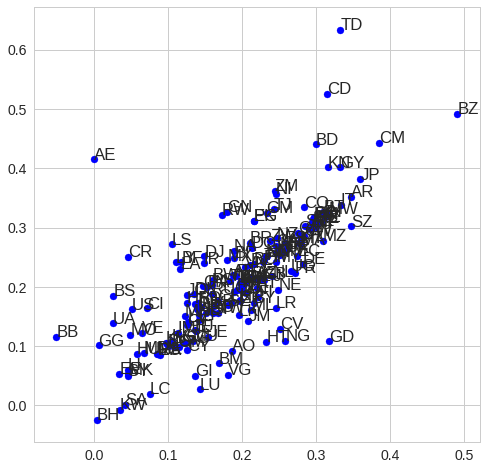

In [232]:
data = []
plt.figure(figsize=(8,8))
for c,x,y,z,t in zip(test.index,test["tax_rate_x"],test["tax_rate_y"],test["zero_profits_y"],test["tax_rate_y"]):
    if np.isnan(x) or np.isnan(y):
        continue
    plt.scatter(x,y,color="b")
    plt.annotate(c,(x,y))
    data.append((c,y-x,z,t))
    

In [233]:
advant = pd.DataFrame(data,columns=["names","advantage","zero_profits","tax_rate"])
advant.sort_values(by="advantage")

,names,advantage,zero_profits,tax_rate
52,GD,-0.209570,0.250000,0.108163
117,NG,-0.149794,0.180047,0.108577
164,VG,-0.129486,0.400000,0.051637
65,HT,-0.125019,0.166667,0.107645
35,CV,-0.121649,0.088889,0.129379
97,LU,-0.115944,0.479760,0.026963
18,BM,-0.097953,0.366667,0.071043
4,AO,-0.094417,0.127976,0.092239
56,GI,-0.086531,0.307143,0.050070
94,LR,-0.080280,0.100000,0.164860


## Average profits vs gdp of country

In [234]:
cofcs = {'SG', 'IE', 'HK', 'NL', 'BB', 'BE', 'PA', 'MH', 'CH', 'GB'}
sofcs = {'GI', 'LR', 'SC', 'GY', 'WS', 'BM', 'GG', 'CW', 'LI', 'VG', 'JE', 'KN', 'CY', 'MU', 'TG', 'BZ', 'KY', 'AI', 'VC', 'BS', 'IM', 'LU'}

gdp = pickle.load(open("../offshore_centers/data/d_iso22gdp.dump","rb"))["2015"]

In [235]:
advant["gdp"] = advant["names"].map(gdp)

In [236]:
advant.loc[advant["names"]=="KY"]

,names,advantage,zero_profits,tax_rate,gdp
87,KY,-0.019074,0.329201,0.178013,3.725867e+09


(-20, 20)

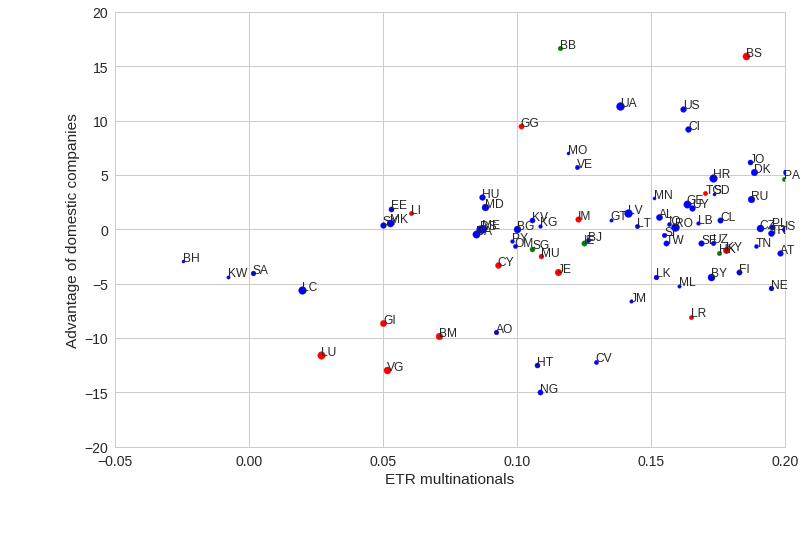

In [243]:
plt.figure(figsize=(12,8))
for c,x,y,z,t in zip(advant["names"],advant["gdp"],100*advant["advantage"],advant["zero_profits"],advant["tax_rate"]):
    if c in cofcs:
        color = "green"
    elif c in sofcs:
        color = "r"
    else:
        color = "b"
    plt.annotate(c,(t,y),fontsize=12)
    plt.scatter(t,y,color=color,s=10+(100*z))

#plt.xscale("log")
plt.xlabel("ETR multinationals")
plt.ylabel("Advantage of domestic companies")
plt.xlim(-0.05,0.2)
plt.ylim(-20,20)

## Evolution of tax in EU

In [219]:
EU = {'NL','BE', 'LT', 'DK', 'HR', 'CY', 'DE', 'IE', 'MT', 'SI', 'SE', 'GB', 'NL', 'HU', 'AT', 'RO', 'CH', 'EE', 'LV', 'LU', 'PT', 'PL', 'IT', 'FI', 'ES', 'GR', 'CZ', 'BG', 'SK', 'FR', 'CH'} 


In [220]:
eu = tax_data_uncons_mult.loc[tax_data_uncons_mult["iso2"].isin(EU)]

In [225]:
"NL" in set(eu["iso2"])

True

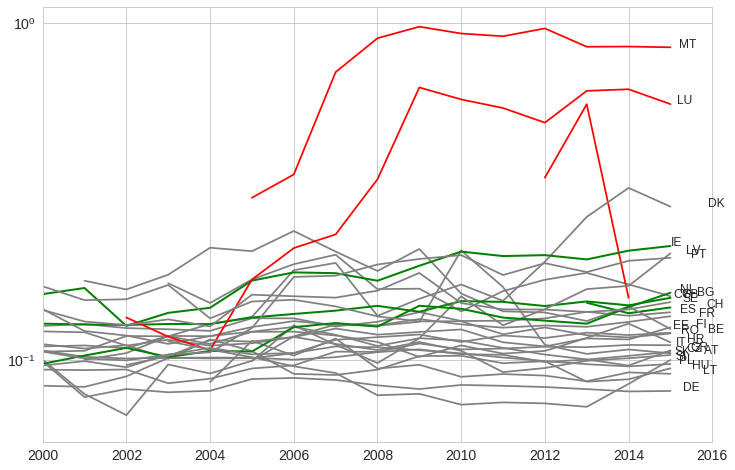

In [228]:
plt.figure(figsize=(12,8))
var = "profit_rate"
for c,data in eu.groupby("iso2"):
    data = data.sort_values(by="year")
    data = data.loc[data["tax_rate_c"]>100]
    data = data.loc[data["year"]<2016]
    if len(data)>0:
        if c in ["IE","CH","NL","GB"]:
            plt.plot(data["year"],data[var],color="green",lw=2)
        elif c in ["LU","MT","CY"]:
            plt.plot(data["year"],data[var],color="red")
        else:
            plt.plot(data["year"],data[var],color="gray")
        ye = 2015+np.random.rand(1)
        plt.annotate(c,(ye,data[var].values[-1]),fontsize=12)
    else:
        print(c)
plt.xlim(2000,2016)
plt.yscale("log")

In [28]:
test = uncons[(uncons["PLbeforeTax"]>1E6)&(uncons["operatingRevenue"]>1E7)].groupby("iso2").median()
test= test.reset_index()
test["gdp"] = test["iso2"].map(gdp)
test.head()

,iso2,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,keepForm,gdp
0,AD,2016.0,25266778.0,12944348.0,402666.0,12541682.0,NaN,6419.0,1.0,3.248925e+09
1,AE,2011.5,315128027.5,127631818.5,59388500.0,17572498.0,NaN,600.0,1.0,3.579492e+11
2,AF,2014.0,19148241.0,6005942.5,877268.5,4726899.0,NaN,6419.0,1.0,1.970299e+10
3,AL,2015.0,24648373.0,2931920.0,478461.0,2448610.0,NaN,4690.0,1.0,1.139037e+10
4,AM,2014.0,20157308.0,7454322.0,1467771.0,5986551.0,NaN,6419.0,1.0,1.052918e+10


In [30]:
test["gdp"] = np.log10(test["gdp"])
test["PLbeforeTax"] = np.log10(test["PLbeforeTax"])
test.head()

,iso2,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,keepForm,gdp
0,AD,2016.0,25266778.0,7.112080,402666.0,12541682.0,NaN,6419.0,1.0,9.511740
1,AE,2011.5,315128027.5,8.105959,59388500.0,17572498.0,NaN,600.0,1.0,11.553821
2,AF,2014.0,19148241.0,6.778581,877268.5,4726899.0,NaN,6419.0,1.0,10.294532
3,AL,2015.0,24648373.0,6.467152,478461.0,2448610.0,NaN,4690.0,1.0,10.056538
4,AM,2014.0,20157308.0,6.872408,1467771.0,5986551.0,NaN,6419.0,1.0,10.022395


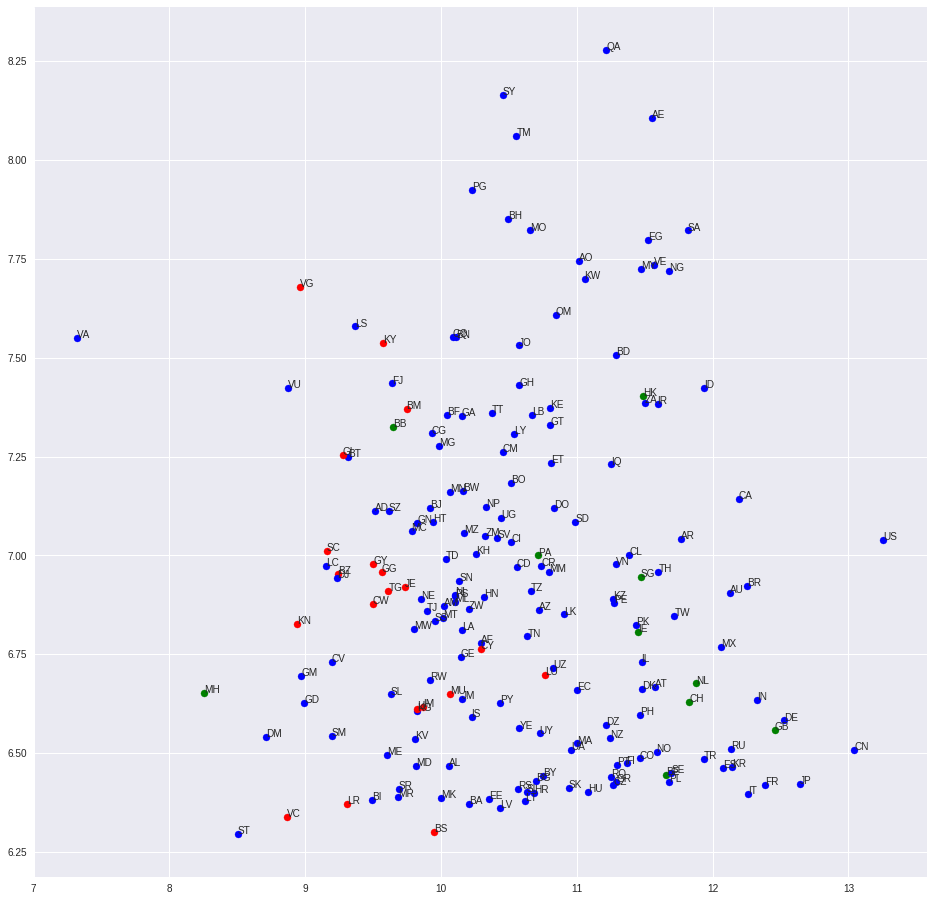

In [31]:
plt.figure(figsize=(16,16))

for c,x,y in zip(test["iso2"],test["gdp"],test["PLbeforeTax"]):
    if np.isnan(x): continue
    if np.isnan(y): continue
    if x < 1: continue
    if y < 1: continue
    if c in cofcs:
        plt.annotate(c,(x,y))
        plt.scatter(x,y,color="green",s=50)
    elif c in sofcs:
        plt.annotate(c,(x,y))
        plt.scatter(x,y,color="red",s=50)
    else:
        plt.annotate(c,(x,y))
        plt.scatter(x,y,color="blue")
plt.show()

## Companies with zero profits

In [45]:
def get_stuff(data):
    data["tax_rate"] = data["Taxation"]/data["PLbeforeTax"]
    tax_rate_cons = data.loc[data["PLbeforeTax"]>1E6].groupby(["iso2","BvD"]).median().groupby("iso2").median()
    zero_profits = data.groupby("iso2")[["PLbeforeTax"]].apply(lambda x: np.sum(x<1E6)/np.sum(np.isfinite(x)))
    zero_profits.columns = ["zero_profits"]

    tax_rate_cons = pd.concat([tax_rate_cons,zero_profits],axis=1)
    return tax_rate_cons

In [46]:
tax_rate_cons = get_stuff(uncons)

In [51]:
tax_rate_cons["PLbeforeTax"] = np.log10(tax_rate_cons["PLbeforeTax"])
tax_rate_cons["Taxation"] = np.log10(tax_rate_cons["Taxation"])
tax_rate_cons["operatingRevenue"] = np.log10(tax_rate_cons["operatingRevenue"])

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [56]:
tax_rate_cons["profit_rate"] = tax_rate_cons["PLbeforeTax"]- tax_rate_cons["operatingRevenue"]

(0, 0.5)

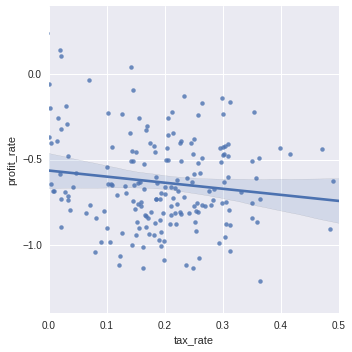

In [57]:
sns.lmplot(x="tax_rate",y="profit_rate",data=tax_rate_cons,robust=True)
#plt.plot(tax_rate_cons["tax_rate"],tax_rate_cons["zero_profits"],'.')
plt.xlim(0,0.5)
#plt.xscale("log")

## Scaling companies

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/robust/norms.py:267: RuntimeWa

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                41998
Model:                            RLM   Df Residuals:                    41996
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 24 Jul 2018                                         
Time:                        19:58:46                                         
No. Iterations:                     2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept               nan        nan  

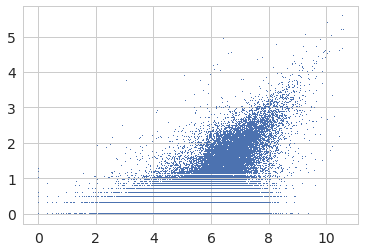

In [252]:

def scaling(df,var1,var2):
    nl_m = tax_data_groupped.loc[tax_data_groupped["multinat"]==True,[var1,var2]]
    nl_m[var1] = np.log10(nl_m[var1])
    nl_m[var2] = np.log10(nl_m[var2])
    nl_m["y"] = nl_m[var2]/nl_m[var1]
    nl_m = nl_m.replace([np.inf,-np.inf],np.NaN).dropna(subset=[var1,var2])
    print(sm.rlm("y~{}".format(var1),data=nl_m).fit().summary())
    plt.plot(nl_m[var1],nl_m[var2],",")
    
    
scaling(tax_data_groupped,"operatingRevenue","numberEmployees")

In [253]:
tax_data_groupped.head()

,,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,fixedAssets,tangibleFixedAssets,numberEmployees,loans,retainedEarnings,status,multinat
BvD,iso2,,,,,,,,,,,,,,
ADFEB59562,AD,2016,2.526678e+07,1.294435e+07,402666,12541682.0,0.0,6419.0,5.041550e+07,0.0,0.0,0.0,0.0,0.0,0.0
AE0000055934,AE,2015,4.773500e+07,3.935000e+06,24000,0.0,0.0,0.0,1.961100e+07,0.0,0.0,0.0,0.0,0.0,0.0
AE0000108403,AE,2015,0.000000e+00,-8.771000e+06,47000,0.0,0.0,2341.0,1.515400e+07,0.0,0.0,0.0,0.0,0.0,0.0
AE30027GU,AE,2012,8.971082e+09,1.812840e+09,23392784,0.0,0.0,6190.0,1.463506e+10,0.0,40000.0,0.0,0.0,0.0,1.0
AE30093GU,AE,2012,1.503740e+05,3.000720e+05,-283,0.0,0.0,6831.0,4.192090e+05,0.0,50.0,0.0,0.0,0.0,1.0


In [318]:
x = tax_data_groupped.reset_index()
x = x.loc[x["multinat"]==1]
#x["count_bvd"] = x[["BvD","Taxation"]].groupby("BvD").transform(len)

x["ETR"] = x["Taxation"]/x["PLafterTax"]
x["PLbeforeTax"] = np.log10(x["PLbeforeTax"])
x = x.loc[x["PLbeforeTax"]>0]
x = x.loc[(x["ETR"]>-1)&((x["ETR"]<1))]

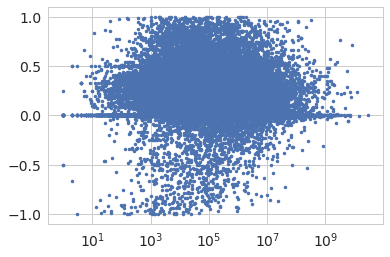

In [321]:
plt.plot(x["PLbeforeTax"],x["ETR"],".")
plt.xscale("log")

In [ ]:
#x = x.loc[x["count_bvd"]>5]
x = x.groupby(["BvD","iso2"]).sum()
x["ETR"] = x["Taxation"]/x["PLafterTax"]
x = x.loc[(x["ETR"]>-1)&((x["ETR"]<1))]

In [315]:
x.head()

,BvD,iso2,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,fixedAssets,tangibleFixedAssets,numberEmployees,loans,retainedEarnings,status,multinat,ETR,count_bvd,mean_country,low_tax


In [314]:
x = x.reset_index()
x["mean_country"] = x[["iso2","ETR"]].groupby("iso2").transform(np.mean)
x["low_tax"] = x["ETR"]<x["mean_country"]/2
x["count"] = x.groupby(["iso2","low_tax"])[["ETR"]].transform(len)
y = x.groupby(["iso2","low_tax"])[["ETR","count"]].mean()
y = y.loc[y["count"]>100].reset_index()
EU2 = {'CY', 'DE', 'MT', 'IT', 'NL', 'SK', 'LV', 'SI', 'CH', 'ES', 'PT', 'LT', 'FI', 'JE', 'HU', 'RO', 'EE', 'GG', 'BG', 'DK', 'PL', 'IE', 'HR', 'AT', 'SE', 'GR', 'FR', 'LU', 'BE', 'GI', 'GB', 'IM', 'CZ'}
y = y.loc[y["iso2"].isin(EU2)]


ValueError: No objects to concatenate

In [ ]:
plt.figure(figsize=(5,10))
sns.barplot(y="iso2",x="ETR",data=y,hue="low_tax",order=y.sort_values(by="ETR",ascending=False)["iso2"].unique())

In [311]:
x.head()

,BvD,iso2,year,operatingRevenue,PLbeforeTax,Taxation,PLafterTax,deferredTaxes,coreNACE,fixedAssets,tangibleFixedAssets,numberEmployees,loans,retainedEarnings,status,multinat,ETR,count_bvd
3,AE30027GU,AE,2012,8.971082e+09,1.812840e+09,23392784,0.0,0.0,6190.0,1.463506e+10,0.0,40000.0,0.0,0.0,0.0,1.0,inf,1
4,AE30093GU,AE,2012,1.503740e+05,3.000720e+05,-283,0.0,0.0,6831.0,4.192090e+05,0.0,50.0,0.0,0.0,0.0,1.0,-inf,1
5,AE30099GU,AE,2015,1.959258e+09,4.900690e+08,73650000,0.0,0.0,5020.0,1.740832e+10,0.0,36000.0,0.0,0.0,0.0,1.0,inf,1
7,AEFEB31240,AE,2012,0.000000e+00,2.857811e+06,-35932,4100120.0,0.0,6419.0,1.397119e+07,0.0,5500.0,0.0,0.0,0.0,1.0,-0.008764,1
8,AEFEB51377,AE,2014,1.683400e+07,3.840000e+06,833000,3007000.0,0.0,6419.0,4.750000e+05,0.0,0.0,0.0,0.0,0.0,1.0,0.277020,1
